# 전처리

In [3]:
import os
import pandas as pd
import numpy as np
import mne
from mne.preprocessing import ICA, create_ecg_epochs, create_eog_epochs
from mne.filter import filter_data, notch_filter
import pickle

# 폴더 경로 설정
eeg_data_path = r"C:\Users\User\Documents\Lie detect data\모의범죄 실험 데이터\EEG 데이터"
code_data_path = r'C:\Users\User\Documents\Lie detect data\모의범죄 실험 데이터\행동 데이터\data'
truth_file_path = r'C:\Users\User\Documents\Lie detect data\모의범죄 실험 데이터\행동 데이터\choice&response.xlsx'
output_data_path = r'C:\Users\User\Documents\Lie detect data\npy 데이터'

# 폴더와 파일 존재 확인
if not os.path.exists(eeg_data_path):
    raise FileNotFoundError(f"EEG 데이터 폴더가 존재하지 않습니다: {eeg_data_path}")
if not os.path.exists(code_data_path):
    raise FileNotFoundError(f"행동 데이터 폴더가 존재하지 않습니다: {code_data_path}")
if not os.path.exists(truth_file_path):
    raise FileNotFoundError(f"진실/거짓 정보 파일이 존재하지 않습니다: {truth_file_path}")
if not os.path.exists(output_data_path):
    os.makedirs(output_data_path)

# 진실/거짓 정보 파일 읽기
truth_df = pd.read_excel(truth_file_path, header=None, index_col=None)
truth_df.columns = ['번호', '항목', '진실/거짓']
truth_info = {str(int(row['번호'])): row['진실/거짓'] == '진실' for idx, row in truth_df.iterrows()}

print("진실/거짓 정보 파일 로드 완료. 첫 5개 항목:")
print(truth_df.head())

# 피험자 파일 리스트
eeg_files = [f for f in os.listdir(eeg_data_path) if f.endswith('.mff')]
print(f"총 {len(eeg_files)}개의 EEG 파일을 발견했습니다.")

# 통합 데이터를 저장할 리스트 초기화
combined_eeg_data = {}
combined_poly_data = {}

def save_epochs(epochs_data, epoch_labels, data_type, participant_number, combined_data):
    labels = set(epoch_labels)
    for label in labels:
        label_indices = [i for i, l in enumerate(epoch_labels) if l == label]
        label_data = [epochs_data[i] for i in label_indices]
        
        # 개별 피험자 데이터 저장
        with open(os.path.join(output_data_path, f"{data_type}_{label}_{participant_number}.pkl"), 'wb') as f:
            pickle.dump(label_data, f)
        
        # 통합 데이터 업데이트
        if label not in combined_data:
            combined_data[label] = label_data
        else:
            combined_data[label].extend(label_data)
    
    print(f"{participant_number}의 {data_type} 데이터가 저장되었습니다.")

def preprocess_and_save_poly(raw_poly, events, event_labels, participant_number):
    # EDA 채널 전처리 (0.5~15 Hz, 60 Hz 노치 필터)
    eda_channel = mne.pick_channels(raw_poly.info['ch_names'], include=['EDA'])
    raw_poly._data[eda_channel, :] = filter_data(raw_poly._data[eda_channel, :], raw_poly.info['sfreq'], l_freq=0.5, h_freq=15, method='fir', fir_design='firwin')
    raw_poly._data[eda_channel, :] = notch_filter(raw_poly._data[eda_channel, :], raw_poly.info['sfreq'], freqs=60, method='fir', fir_design='firwin')

    # PPG 채널 전처리 (0.01~15 Hz, 60 Hz 노치 필터)
    ppg_channel = mne.pick_channels(raw_poly.info['ch_names'], include=['PPG'])
    raw_poly._data[ppg_channel, :] = filter_data(raw_poly._data[ppg_channel, :], raw_poly.info['sfreq'], l_freq=0.01, h_freq=15, method='fir', fir_design='firwin')
    raw_poly._data[ppg_channel, :] = notch_filter(raw_poly._data[ppg_channel, :], raw_poly.info['sfreq'], freqs=60, method='fir', fir_design='firwin')

    # Resp. Effort 채널 전처리 (1~15 Hz, 60 Hz 노치 필터)
    resp_channel = mne.pick_channels(raw_poly.info['ch_names'], include=['Resp. Effort'])
    raw_poly._data[resp_channel, :] = filter_data(raw_poly._data[resp_channel, :], raw_poly.info['sfreq'], l_freq=1, h_freq=15, method='fir', fir_design='firwin')
    raw_poly._data[resp_channel, :] = notch_filter(raw_poly._data[resp_channel, :], raw_poly.info['sfreq'], freqs=60, method='fir', fir_design='firwin')

    # ECG 채널 전처리 (1~70 Hz, 60 Hz 노치 필터)
    ecg_channel = mne.pick_channels(raw_poly.info['ch_names'], include=['ECG'])
    raw_poly._data[ecg_channel, :] = filter_data(raw_poly._data[ecg_channel, :], raw_poly.info['sfreq'], l_freq=1, h_freq=70, method='fir', fir_design='firwin')
    raw_poly._data[ecg_channel, :] = notch_filter(raw_poly._data[ecg_channel, :], raw_poly.info['sfreq'], freqs=60, method='fir', fir_design='firwin')

    # 폴리그래프 데이터 에포킹
    epochs_list = []
    epoch_labels = []
    for i in range(len(events)):
        event_id = events[i][2]
        onset = events[i][0]

        if event_id <= 6:
            if 'que' in event_labels[i]:
                try:
                    ans_event_index = next(j for j in range(i + 1, len(events)) if 'ans' in event_labels[j])
                    end_onset = events[ans_event_index][0]
                    epochs_list.append([onset, end_onset])
                    epoch_labels.append(event_labels[i])
                except StopIteration:
                    pass
            elif 'ans' in event_labels[i]:
                end_onset = onset + int(10 * raw_poly.info['sfreq'])
                epochs_list.append([onset, end_onset])
                epoch_labels.append(event_labels[i])

    epochs_data = []
    for start, end in epochs_list:
        if end <= len(raw_poly.times):
            epoch_data = raw_poly.get_data(start=start, stop=end)
            epochs_data.append(epoch_data)

    print(f"{participant_number}의 폴리그래프 데이터 에포킹 완료. 총 {len(epochs_data)}개의 에포크")
    save_epochs(epochs_data, epoch_labels, 'poly', participant_number, combined_poly_data)

def process_participant_data(participant_number):    
    eeg_file = next(f for f in eeg_files if participant_number in f)
    file_path = os.path.join(eeg_data_path, eeg_file)
    code_file = next(f for f in os.listdir(code_data_path) if participant_number in f)

    # 파일 존재 여부 확인
    if not os.path.exists(file_path):
        print(f"EEG 파일이 존재하지 않습니다: {file_path}")
        return
    if not os.path.exists(os.path.join(code_data_path, code_file)):
        print(f"행동 데이터 파일이 존재하지 않습니다: {code_file}")
        return

    # 데이터 로드
    raw = mne.io.read_raw_egi(file_path, preload=True)
    raw.resample(250)
    print(f"{participant_number}의 EEG 데이터 로드 및 리샘플링 완료")

    # EEG 채널과 폴리그래프 채널 분리
    eeg_channels = mne.pick_types(raw.info, eeg=True, stim=False, bio=False, ecg=False, eog=False)
    bio_channels = mne.pick_types(raw.info, eeg=False, stim=False, bio=True, ecg=True, eog=False)

    print(f"선택된 EEG 채널: {len(eeg_channels)}개, 선택된 Bio 채널: {len(bio_channels)}개")

    # EEG 데이터 전처리
    raw_eeg = raw.copy().pick(eeg_channels)
    raw_eeg.filter(0.1, 50, fir_design='firwin')
    raw_eeg.notch_filter(freqs=[60, 120], fir_design='firwin')
    raw_eeg.set_eeg_reference('average', projection=True)
    raw_eeg.apply_proj()
    print(f"{participant_number}의 EEG 데이터 전처리 완료")

    # ICA to remove ECG and EOG artifacts
    ica = ICA(n_components=15, random_state=97, max_iter=800)
    ica.fit(raw_eeg)

    # ECG 아티팩트를 찾고 제거
    ecg_epochs = create_ecg_epochs(raw, ch_name='ECG')
    ecg_indices, ecg_scores = ica.find_bads_ecg(ecg_epochs, method='correlation', threshold='auto')
    ica.exclude.extend(ecg_indices)

    # EOG 아티팩트를 수동으로 찾고 제거 (E1 채널 사용)
    eog_indices, eog_scores = ica.find_bads_eog(raw_eeg, ch_name='E1')
    ica.exclude.extend(eog_indices)

    # ICA 적용
    ica.apply(raw_eeg)
    print(f"{participant_number}의 ICA 적용 완료")

    # 폴리그래프 데이터 전처리
    raw_poly = raw.copy().pick(bio_channels)

    # EDA 채널 전처리 (0.5~15 Hz, 60 Hz 노치 필터)
    eda_channel = mne.pick_channels(raw_poly.info['ch_names'], include=['EDA'])
    raw_poly._data[eda_channel, :] = filter_data(raw_poly._data[eda_channel, :], raw_poly.info['sfreq'], l_freq=0.5, h_freq=15, method='fir', fir_design='firwin')
    raw_poly._data[eda_channel, :] = notch_filter(raw_poly._data[eda_channel, :], raw_poly.info['sfreq'], freqs=60, method='fir', fir_design='firwin')

    # PPG 채널 전처리 (0.01~15 Hz, 60 Hz 노치 필터)
    ppg_channel = mne.pick_channels(raw_poly.info['ch_names'], include=['PPG'])
    raw_poly._data[ppg_channel, :] = filter_data(raw_poly._data[ppg_channel, :], raw_poly.info['sfreq'], l_freq=0.01, h_freq=15, method='fir', fir_design='firwin')
    raw_poly._data[ppg_channel, :] = notch_filter(raw_poly._data[ppg_channel, :], raw_poly.info['sfreq'], freqs=60, method='fir', fir_design='firwin')

    # Resp. Effort 채널 전처리 (1~15 Hz, 60 Hz 노치 필터)
    resp_channel = mne.pick_channels(raw_poly.info['ch_names'], include=['Resp. Effort'])
    raw_poly._data[resp_channel, :] = filter_data(raw_poly._data[resp_channel, :], raw_poly.info['sfreq'], l_freq=1, h_freq=15, method='fir', fir_design='firwin')
    raw_poly._data[resp_channel, :] = notch_filter(raw_poly._data[resp_channel, :], raw_poly.info['sfreq'], freqs=60, method='fir', fir_design='firwin')

    # ECG 채널 전처리 (1~70 Hz, 60 Hz 노치 필터)
    ecg_channel = mne.pick_channels(raw_poly.info['ch_names'], include=['ECG'])
    raw_poly._data[ecg_channel, :] = filter_data(raw_poly._data[ecg_channel, :], raw_poly.info['sfreq'], l_freq=1, h_freq=70, method='fir', fir_design='firwin')
    raw_poly._data[ecg_channel, :] = notch_filter(raw_poly._data[ecg_channel, :], raw_poly.info['sfreq'], freqs=60, method='fir', fir_design='firwin')

    # 이벤트 마커 추출
    events = mne.find_events(raw)

    # 이벤트 ID 매핑 생성
    event_mapping = {}
    event_counter = 1

    # 코드와 코드2 열의 값을 이벤트 ID와 매핑
    code_df = pd.read_csv(os.path.join(code_data_path, code_file))
    print(f"{participant_number}의 행동 데이터 로드 완료. 첫 5개 행:")
    print(code_df.head())

    for _, row in code_df.iterrows():
        code_value = row['code']
        code2_value = row['code2']

        if pd.notna(code_value) and code_value not in event_mapping:
            event_mapping[code_value] = event_counter
            event_counter += 1

        if pd.notna(code2_value) and code2_value not in event_mapping:
            event_mapping[code2_value] = event_counter
            event_counter += 1

    # quer와 ansr 이벤트의 인덱스를 추적
    quer_count = 0
    ansr_count = 0

    # 이벤트 라벨링
    event_labels = []
    row_index = 0
    is_code = True  # True면 code 열을, False면 code2 열을 참조

    for event in events:
        event_id = event[2]
        label = None

        if row_index < len(code_df):
            row = code_df.iloc[row_index]
            participant_number_split = str(int(participant_number.split('_')[1]))  # 피험자 번호 추출 및 앞의 0 제거
            is_truth = truth_info.get(participant_number_split, False)

            # code와 code2를 순차적으로 참조
            current_code = row['code'] if is_code else row['code2']

            if is_truth:
                if current_code == 'quer':
                    label = 'quer_truth'
                elif current_code == 'ansr':
                    label = 'ansr_truth'
                else:
                    label = current_code
            else:
                if current_code == 'quer':
                    quer_count += 1
                    if quer_count in [3, 4]:
                        quer_keys = row['key_resp_8.keys'].split(',')
                        if 'j' in quer_keys:
                            label = 'quer_truth'
                        else:
                            label = 'quer_lie'
                    else:
                        label = 'quer_lie'
                elif current_code == 'ansr':
                    ansr_count += 1
                    if ansr_count in [3, 4]:
                        ansr_keys = row['key_resp_8.keys'].split(',')
                        if 'j' in ansr_keys:
                            label = 'ansr_truth'
                        else:
                            label = 'ansr_lie'
                    else:
                        label = 'ansr_lie'
                else:
                    label = current_code

            # 다음 이벤트에서는 code2 열을 참조
            if is_code:
                is_code = False
            else:
                row_index += 1
                is_code = True

        event_labels.append(label)

    print(f"{participant_number}의 이벤트 라벨링 완료. 첫 10개 이벤트:")
    print(event_labels[:10])

    # 에포크 생성
    epochs_list = []
    epoch_labels = []
    for i in range(len(events)):
        event_id = events[i][2]
        onset = events[i][0]

        # 1, 2세트 이벤트 (1~6번 이벤트)만 사용
        if event_id <= 6:
            # que 이벤트인 경우
            if 'que' in event_labels[i]:
                try:
                    ans_event_index = next(j for j in range(i + 1, len(events)) if 'ans' in event_labels[j])
                    end_onset = events[ans_event_index][0]
                    epochs_list.append([onset, end_onset])
                    epoch_labels.append(event_labels[i])
                except StopIteration:
                    pass

            # ans 이벤트인 경우
            elif 'ans' in event_labels[i]:
                end_onset = onset + int(10 * raw.info['sfreq'])
                epochs_list.append([onset, end_onset])
                epoch_labels.append(event_labels[i])

    # 에포크 생성
    epochs_data = []
    for start, end in epochs_list:
        if end <= len(raw_eeg.times):
            epoch_data = raw_eeg.get_data(start=start, stop=end)
            epochs_data.append(epoch_data)
            print(f"Epoch from {start} to {end} with shape: {epoch_data.shape}")

    # EEG 데이터 저장
    save_epochs(epochs_data, epoch_labels, 'eeg', participant_number, combined_eeg_data)

    # 폴리그래프 데이터 저장
    preprocess_and_save_poly(raw_poly, events, event_labels, participant_number)

    print(f"Participant {participant_number} data processing complete.")

# 모든 피험자에 대해 반복 처리
for eeg_file in eeg_files:
    # 피험자 번호 추출
    participant_number = "_".join(eeg_file.split('_')[1:3])
    
    # 데이터 처리 함수 호출
    process_participant_data(participant_number)

# 통합 데이터 저장
for label, data in combined_eeg_data.items():
    print(f"Combining EEG data for label {label} with {len(data)} epochs")
    np.save(os.path.join(output_data_path, f"combined_eeg_{label}.npy"), np.array(data, dtype=object))

for label, data in combined_poly_data.items():
    print(f"Combining Poly data for label {label} with {len(data)} epochs")
    np.save(os.path.join(output_data_path, f"combined_poly_{label}.npy"), np.array(data, dtype=object))

print("모든 피험자 데이터 처리가 완료되었습니다.")


진실/거짓 정보 파일 로드 완료. 첫 5개 항목:
   번호  항목 진실/거짓
0   1  현금    거짓
1   2  현금    거짓
2   3  인형    진실
3   4  현금    진실
4   5  현금    거짓
총 15개의 EEG 파일을 발견했습니다.
Reading EGI MFF Header from C:\Users\User\Documents\Lie detect data\모의범죄 실험 데이터\EEG 데이터\lie_1_01_20240522_105710.mff...
    Reading events ...
    Assembling measurement info ...
    Synthesizing trigger channel "STI 014" ...
    Excluding events {} ...
Reading 0 ... 215226  =      0.000 ...   430.452 secs...
52 events found on stim channel STI 014
Event IDs: [1 2 3 4 5 6 7 8]
52 events found on stim channel STI 014
Event IDs: [1 2 3 4 5 6 7 8]
1_01의 EEG 데이터 로드 및 리샘플링 완료
선택된 EEG 채널: 65개, 선택된 Bio 채널: 4개
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)

EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


SSP projectors applied...
1_01의 EEG 데이터 전처리 완료
Fitting ICA to data using 65 channels (please be patient, this may take a while)
    Applying projection operator with 1 vector (pre-whitener computation)
    Applying projection operator with 1 vector (pre-whitener application)
Selecting by number: 15 components
    Applying projection operator with 1 vector (pre-whitener application)
Fitting ICA took 4.3s.
Using channel ECG to identify heart beats.
Setting up band-pass filter from 8 - 16 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 8.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 7.75 Hz)
- Upper passband edge: 16.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 16.25 Hz)
- Filter length: 2500 samples (10.000 s)

Number of ECG events detected : 770 (average pulse 107 / min.)
N

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
1_02의 EEG 데이터 전처리 완료
Fitting ICA to data using 65 channels (please be patient, this may take a while)
    Applying projection operator with 1 vector (pre-whitener computation)
    Applying projection operator with 1 vector (pre-whitener application)
Selecting by number: 15 components
    Applying projection operator with 1 vector (pre-whitener application)
Fitting ICA took 3.6s.
Using channel ECG to identify heart beats.
Setting up band-pass filter from 8 - 16 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower p

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
1_03의 EEG 데이터 전처리 완료
Fitting ICA to data using 65 channels (please be patient, this may take a while)
    Applying projection operator with 1 vector (pre-whitener computation)
    Applying projection operator with 1 vector (pre-whitener application)
Selecting by number: 15 components
    Applying projection operator with 1 vector (pre-whitener application)
Fitting ICA took 3.3s.
Using channel ECG to identify heart beats.
Setting up band-pass filter from 8 - 16 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower p

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
1_04의 EEG 데이터 전처리 완료
Fitting ICA to data using 65 channels (please be patient, this may take a while)
    Applying projection operator with 1 vector (pre-whitener computation)
    Applying projection operator with 1 vector (pre-whitener application)
Selecting by number: 15 components
    Applying projection operator with 1 vector (pre-whitener application)
Fitting ICA took 4.2s.
Using channel ECG to identify heart beats.
Setting up band-pass filter from 8 - 16 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower p

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
1_05의 EEG 데이터 전처리 완료
Fitting ICA to data using 65 channels (please be patient, this may take a while)
    Applying projection operator with 1 vector (pre-whitener computation)
    Applying projection operator with 1 vector (pre-whitener application)
Selecting by number: 15 components
    Applying projection operator with 1 vector (pre-whitener application)
Fitting ICA took 4.1s.
Using channel ECG to identify heart beats.
Setting up band-pass filter from 8 - 16 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower p

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
1_06의 EEG 데이터 전처리 완료
Fitting ICA to data using 65 channels (please be patient, this may take a while)
    Applying projection operator with 1 vector (pre-whitener computation)
    Applying projection operator with 1 vector (pre-whitener application)
Selecting by number: 15 components
    Applying projection operator with 1 vector (pre-whitener application)
Fitting ICA took 4.4s.
Using channel ECG to identify heart beats.
Setting up band-pass filter from 8 - 16 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower p

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


SSP projectors applied...
1_07의 EEG 데이터 전처리 완료
Fitting ICA to data using 65 channels (please be patient, this may take a while)
    Applying projection operator with 1 vector (pre-whitener computation)
    Applying projection operator with 1 vector (pre-whitener application)
Selecting by number: 15 components
    Applying projection operator with 1 vector (pre-whitener application)
Fitting ICA took 5.0s.
Using channel ECG to identify heart beats.
Setting up band-pass filter from 8 - 16 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 8.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 7.75 Hz)
- Upper passband edge: 16.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 16.25 Hz)
- Filter length: 2500 samples (10.000 s)

Number of ECG events detected : 449 (average pulse 66 / min.)
No

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
1_09의 EEG 데이터 전처리 완료
Fitting ICA to data using 65 channels (please be patient, this may take a while)
    Applying projection operator with 1 vector (pre-whitener computation)
    Applying projection operator with 1 vector (pre-whitener application)
Selecting by number: 15 components
    Applying projection operator with 1 vector (pre-whitener application)
Fitting ICA took 4.0s.
Using channel ECG to identify heart beats.
Setting up band-pass filter from 8 - 16 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower p

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
1_10의 EEG 데이터 전처리 완료
Fitting ICA to data using 65 channels (please be patient, this may take a while)
    Applying projection operator with 1 vector (pre-whitener computation)
    Applying projection operator with 1 vector (pre-whitener application)
Selecting by number: 15 components
    Applying projection operator with 1 vector (pre-whitener application)
Fitting ICA took 5.6s.
Using channel ECG to identify heart beats.
Setting up band-pass filter from 8 - 16 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower p

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
1_12의 EEG 데이터 전처리 완료
Fitting ICA to data using 65 channels (please be patient, this may take a while)
    Applying projection operator with 1 vector (pre-whitener computation)
    Applying projection operator with 1 vector (pre-whitener application)
Selecting by number: 15 components
    Applying projection operator with 1 vector (pre-whitener application)
Fitting ICA took 3.6s.
Using channel ECG to identify heart beats.
Setting up band-pass filter from 8 - 16 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower p

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)

EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


SSP projectors applied...
1_13의 EEG 데이터 전처리 완료
Fitting ICA to data using 65 channels (please be patient, this may take a while)
    Applying projection operator with 1 vector (pre-whitener computation)
    Applying projection operator with 1 vector (pre-whitener application)
Selecting by number: 15 components
    Applying projection operator with 1 vector (pre-whitener application)
Fitting ICA took 5.3s.
Using channel ECG to identify heart beats.
Setting up band-pass filter from 8 - 16 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 8.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 7.75 Hz)
- Upper passband edge: 16.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 16.25 Hz)
- Filter length: 2500 samples (10.000 s)

Number of ECG events detected : 741 (average pulse 104 / min.)
N

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
1_14의 EEG 데이터 전처리 완료
Fitting ICA to data using 65 channels (please be patient, this may take a while)
    Applying projection operator with 1 vector (pre-whitener computation)
    Applying projection operator with 1 vector (pre-whitener application)
Selecting by number: 15 components
    Applying projection operator with 1 vector (pre-whitener application)
Fitting ICA took 5.8s.
Using channel ECG to identify heart beats.
Setting up band-pass filter from 8 - 16 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower p

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


SSP projectors applied...
1_15의 EEG 데이터 전처리 완료
Fitting ICA to data using 65 channels (please be patient, this may take a while)
    Applying projection operator with 1 vector (pre-whitener computation)
    Applying projection operator with 1 vector (pre-whitener application)
Selecting by number: 15 components
    Applying projection operator with 1 vector (pre-whitener application)
Fitting ICA took 5.1s.
Using channel ECG to identify heart beats.
Setting up band-pass filter from 8 - 16 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 8.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 7.75 Hz)
- Upper passband edge: 16.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 16.25 Hz)
- Filter length: 2500 samples (10.000 s)

Number of ECG events detected : 672 (average pulse 102 / min.)
N

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
1_16의 EEG 데이터 전처리 완료
Fitting ICA to data using 65 channels (please be patient, this may take a while)
    Applying projection operator with 1 vector (pre-whitener computation)
    Applying projection operator with 1 vector (pre-whitener application)
Selecting by number: 15 components
    Applying projection operator with 1 vector (pre-whitener application)
Fitting ICA took 6.7s.
Using channel ECG to identify heart beats.
Setting up band-pass filter from 8 - 16 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower p

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
1_18의 EEG 데이터 전처리 완료
Fitting ICA to data using 65 channels (please be patient, this may take a while)
    Applying projection operator with 1 vector (pre-whitener computation)
    Applying projection operator with 1 vector (pre-whitener application)
Selecting by number: 15 components
    Applying projection operator with 1 vector (pre-whitener application)
Fitting ICA took 5.6s.
Using channel ECG to identify heart beats.
Setting up band-pass filter from 8 - 16 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower p

ValueError: could not broadcast input array from shape (65,458) into shape (65,)

# 검증

In [5]:
import os
import numpy as np
import pandas as pd
import pickle

# 파일 경로 설정
directory_path = r"C:\Users\User\Documents\Lie detect data\npy 데이터"
output_excel_path = os.path.join(directory_path, 'data_shapes.xlsx')

# 지정된 경로에 있는 파일들의 shape 정보를 엑셀 파일로 저장
def save_shapes_to_excel(path, output_path):
    file_data = []

    # 지정된 경로의 모든 파일에 대해 반복
    for file in os.listdir(path):
        if file.endswith('.pkl'):
            file_path = os.path.join(path, file)
            try:
                with open(file_path, 'rb') as f:
                    data = pickle.load(f)
                    # 데이터 shape 확인
                    if isinstance(data, list):
                        shapes = [arr.shape for arr in data if isinstance(arr, np.ndarray)]
                        file_data.append([file, shapes])
                    else:
                        file_data.append([file, data.shape])
            except Exception as e:
                print(f"파일 로드 실패: {file_path} - {e}")

    # 데이터프레임으로 변환
    df = pd.DataFrame(file_data, columns=['파일 이름', 'Shapes'])
    
    # 엑셀 파일로 저장
    df.to_excel(output_path, index=False)
    print(f"데이터 shape 정보가 '{output_path}'에 저장되었습니다.")

save_shapes_to_excel(directory_path, output_excel_path)


데이터 shape 정보가 'C:\Users\User\Documents\Lie detect data\npy 데이터\data_shapes.xlsx'에 저장되었습니다.


# EEGNet

In [1]:
import os
import pickle
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import KFold

# 데이터 경로 설정
data_path = r"C:\Users\User\Documents\Lie detect data\npy 데이터"

# 데이터 로드 함수
def load_data(data_path):
    data = {}
    for file_name in os.listdir(data_path):
        if file_name.endswith('.pkl'):
            with open(os.path.join(data_path, file_name), 'rb') as file:
                data[file_name] = pickle.load(file)
    return data

# 피험자 ID 추출 함수
def extract_subject_ids(data):
    truth_subjects = set()
    lie_subjects = set()

    for name in data.keys():
        parts = name.split('_')
        if len(parts) >= 5:
            subject_id = parts[4].replace('.pkl', '')
        elif len(parts) == 4:
            subject_id = parts[3].replace('.pkl', '')
        else:
            continue
        
        if 'truth' in name:
            truth_subjects.add(subject_id)
        elif 'lie' in name:
            lie_subjects.add(subject_id)

    # 진실 ID에서 거짓 ID 제거
    truth_subjects = [subj for subj in truth_subjects if subj not in lie_subjects]
    
    return truth_subjects, list(lie_subjects)

# 4명의 피험자 랜덤 추출 함수 (2명 진실, 2명 거짓)
def select_random_subjects(truth_subjects, lie_subjects, num_each=2):
    test_truth_subjects = random.sample(truth_subjects, num_each)
    test_lie_subjects = random.sample(lie_subjects, num_each)
    
    train_truth_subjects = [subj for subj in truth_subjects if subj not in test_truth_subjects]
    train_lie_subjects = [subj for subj in lie_subjects if subj not in test_lie_subjects]
    
    return test_truth_subjects, test_lie_subjects, train_truth_subjects, train_lie_subjects

# 데이터 로드
data = load_data(data_path)

# 피험자 ID 분류
truth_subjects, lie_subjects = extract_subject_ids(data)

# 4명의 피험자 랜덤 추출
test_truth_subjects, test_lie_subjects, train_truth_subjects, train_lie_subjects = select_random_subjects(truth_subjects, lie_subjects)

# 훈련 데이터와 테스트 데이터를 분류하는 함수
def split_data(data, test_truth_subjects, test_lie_subjects):
    train_data = {}
    test_data = {}
    
    for key, value in data.items():
        parts = key.split('_')
        if len(parts) >= 5:
            subject_id = parts[4].replace('.pkl', '')
        elif len(parts) == 4:
            subject_id = parts[3].replace('.pkl', '')
        else:
            continue
            
        if subject_id in test_truth_subjects or subject_id in test_lie_subjects:
            test_data[key] = value
        else:
            train_data[key] = value
                
    return train_data, test_data

# 훈련 데이터와 테스트 데이터 분류
train_data, test_data = split_data(data, test_truth_subjects, test_lie_subjects)

# 결과 출력
print("훈련 데이터 수:", len(train_data))
print("테스트 데이터 수:", len(test_data))
print("테스트 진실 피험자:", test_truth_subjects)
print("테스트 거짓 피험자:", test_lie_subjects)



훈련 데이터 수: 152
테스트 데이터 수: 56
테스트 진실 피험자: ['10', '07']
테스트 거짓 피험자: ['13', '02']


In [2]:
import numpy as np
import os
import pickle
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

class EEGNet(nn.Module):
    def __init__(self, num_classes, channels=64, samples=128, dropout_rate=0.5, kernel_length=64, F1=8, D=2, F2=16, norm_rate=0.25):
        super(EEGNet, self).__init__()
        self.num_classes = num_classes
        self.channels = channels
        self.samples = samples
        self.dropout_rate = dropout_rate
        self.kernel_length = kernel_length
        self.F1 = F1
        self.D = D
        self.F2 = F2
        self.norm_rate = norm_rate

        self.firstconv = nn.Sequential(
            nn.Conv2d(1, self.F1, (1, self.kernel_length), padding=(0, self.kernel_length // 2), bias=False),
            nn.BatchNorm2d(self.F1)
        )

        self.depthwiseConv = nn.Sequential(
            nn.Conv2d(self.F1, self.F1 * self.D, (self.channels, 1), groups=self.F1, bias=False),
            nn.BatchNorm2d(self.F1 * self.D),
            nn.ELU(),
            nn.AvgPool2d((1, 4)),
            nn.Dropout(self.dropout_rate)
        )

        self.separableConv = nn.Sequential(
            nn.Conv2d(self.F1 * self.D, self.F2, (1, 16), padding=(0, 8), bias=False),
            nn.BatchNorm2d(self.F2),
            nn.ELU(),
            nn.AvgPool2d((1, 8)),
            nn.Dropout(self.dropout_rate)
        )

        self.classify = None  # Linear layer will be defined in the forward method based on the input size

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.firstconv(x)
        x = self.depthwiseConv(x)
        x = self.separableConv(x)
        x = x.view(x.size(0), -1)
        if self.classify is None:
            self.classify = nn.Linear(x.size(1), self.num_classes).to(x.device)
        x = self.classify(x)
        return torch.sigmoid(x)

def load_data(data_path):
    data = {}
    for file_name in os.listdir(data_path):
        if file_name.endswith('.pkl'):
            with open(os.path.join(data_path, file_name), 'rb') as file:
                data[file_name] = pickle.load(file)
    return data

def extract_subject_ids(data):
    truth_subjects = set()
    lie_subjects = set()

    for name in data.keys():
        parts = name.split('_')
        if len(parts) >= 5:
            subject_id = parts[4].replace('.pkl', '')
        elif len(parts) == 4:
            subject_id = parts[3].replace('.pkl', '')
        else:
            continue
        
        if 'truth' in name:
            truth_subjects.add(subject_id)
        elif 'lie' in name:
            lie_subjects.add(subject_id)

    # 진실 ID에서 거짓 ID 제거
    truth_subjects = [subj for subj in truth_subjects if subj not in lie_subjects]
    
    return truth_subjects, list(lie_subjects)

def select_random_subjects(truth_subjects, lie_subjects, num_each=2):
    if len(truth_subjects) < num_each or len(lie_subjects) < num_each:
        raise ValueError("Not enough subjects in one of the groups to select the required number of samples.")
    
    test_truth_subjects = random.sample(truth_subjects, num_each)
    test_lie_subjects = random.sample(lie_subjects, num_each)
    
    train_truth_subjects = [subj for subj in truth_subjects if subj not in test_truth_subjects]
    train_lie_subjects = [subj for subj in lie_subjects if subj not in test_lie_subjects]
    
    return test_truth_subjects, test_lie_subjects, train_truth_subjects, train_lie_subjects

def split_data(data, test_truth_subjects, test_lie_subjects):
    train_data = {'eeg': []}
    test_data = {'eeg': []}

    for key, value in data.items():
        parts = key.split('_')
        if len(parts) >= 5:
            subject_id = parts[4].replace('.pkl', '')
        elif len(parts) == 4:
            subject_id = parts[3].replace('.pkl', '')
        else:
            continue

        for sample in value:
            sample_data = {'data': sample, 'subject_id': subject_id}

            if subject_id in test_truth_subjects or subject_id in test_lie_subjects:
                if 'eeg' in key and ('quer_truth' in key or 'quer_lie' in key):
                    test_data['eeg'].append((sample_data, 'truth' in key))
            else:
                if 'eeg' in key and ('quer_truth' in key or 'quer_lie' in key):
                    train_data['eeg'].append((sample_data, 'truth' in key))

    return train_data, test_data

def collate_fn(batch):
    max_len = 2500
    data, labels, subject_ids = zip(*batch)
    data = [d.transpose(0, 1) for d in data]
    data_padded = pad_sequence(data, batch_first=True, padding_value=0)

    if data_padded.size(1) > max_len:
        data_padded = data_padded[:, :max_len, :]
    else:
        pad_size = max_len - data_padded.size(1)
        data_padded = torch.nn.functional.pad(data_padded, (0, 0, 0, pad_size))

    return data_padded, torch.tensor(labels), torch.tensor([d.size(1) for d in data]), list(subject_ids)

class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample, label = self.data[idx]
        data, subject_id = sample['data'], sample['subject_id']
        label = 1 if label else 0
        return torch.tensor(data, dtype=torch.float32), torch.tensor(label, dtype=torch.float32), subject_id

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def train_model(model, train_loader, optimizer, criterion, num_epochs=100):
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)
    best_loss = float('inf')

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels, lengths, subject_ids in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        scheduler.step(running_loss / len(train_loader))

        print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {running_loss/len(train_loader)}")

def ensemble_predict(model, eeg_loader):
    model.eval()
    all_predictions = {}
    with torch.no_grad():
        for eeg_inputs, eeg_labels, eeg_lengths, eeg_subject_ids in eeg_loader:
            eeg_inputs = eeg_inputs.to(device)

            eeg_outputs = model(eeg_inputs)

            predictions = (eeg_outputs > 0.5).float()

            for subject_id, prediction in zip(eeg_subject_ids, predictions):
                if subject_id not in all_predictions:
                    all_predictions[subject_id] = []
                all_predictions[subject_id].append(prediction.item())

    final_predictions = {}
    for subject_id, preds in all_predictions.items():
        avg_prediction = np.mean(preds)
        final_predictions[subject_id] = 'Truth' if avg_prediction >= 0.5 else 'Lie'

    return final_predictions

def evaluate(predictions, true_labels):
    true_vals = []
    pred_vals = []
    
    for subject_id in true_labels.keys():
        true_vals.append(1 if true_labels[subject_id] == 'Truth' else 0)
        pred_vals.append(1 if predictions[subject_id] == 'Truth' else 0)
    
    accuracy = accuracy_score(true_vals, pred_vals)
    precision = precision_score(true_vals, pred_vals)
    recall = recall_score(true_vals, pred_vals)
    f1 = f1_score(true_vals, pred_vals)
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    
    return accuracy, precision, recall, f1

def main(data_path, num_repeats=10):
    data = load_data(data_path)
    truth_subjects, lie_subjects = extract_subject_ids(data)
    accuracies = []
    precisions = []
    recalls = []
    f1_scores = []

    for i in range(num_repeats):
        test_truth_subjects, test_lie_subjects, train_truth_subjects, train_lie_subjects = select_random_subjects(truth_subjects, lie_subjects)
        train_data, test_data = split_data(data, test_truth_subjects, test_lie_subjects)

        train_eeg_loader = DataLoader(CustomDataset(train_data['eeg']), batch_size=8, shuffle=True, collate_fn=collate_fn)
        test_eeg_loader = DataLoader(CustomDataset(test_data['eeg']), batch_size=8, shuffle=False, collate_fn=collate_fn)

        eeg_model = EEGNet(num_classes=1, channels=65, samples=2500)
        eeg_model.to(device)

        eeg_optimizer = optim.Adam(eeg_model.parameters(), lr=0.001)
        criterion = nn.BCELoss()

        print(f"Training model for run {i+1}...")
        train_model(eeg_model, train_eeg_loader, eeg_optimizer, criterion, num_epochs=100)

        predictions = ensemble_predict(eeg_model, test_eeg_loader)

        true_labels = {
            subj: 'Truth' for subj in test_truth_subjects
        }
        true_labels.update({
            subj: 'Lie' for subj in test_lie_subjects
        })

        accuracy, precision, recall, f1 = evaluate(predictions, true_labels)
        accuracies.append(accuracy)
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)

    print(f"Average Accuracy over {num_repeats} runs: {np.mean(accuracies):.4f}")
    print(f"Average Precision over {num_repeats} runs: {np.mean(precisions):.4f}")
    print(f"Average Recall over {num_repeats} runs: {np.mean(recalls):.4f}")
    print(f"Average F1 Score over {num_repeats} runs: {np.mean(f1_scores):.4f}")

if __name__ == "__main__":
    main(r"C:\Users\User\Documents\Lie detect data\npy 데이터")


Training model for run 1...
Epoch 1/100, Training Loss: 0.6699909435378181
Epoch 2/100, Training Loss: 0.5537414219644334
Epoch 3/100, Training Loss: 0.51023002465566
Epoch 4/100, Training Loss: 0.49990271197424996
Epoch 5/100, Training Loss: 0.5157982110977173
Epoch 6/100, Training Loss: 0.47253162331051296
Epoch 7/100, Training Loss: 0.460335652033488
Epoch 8/100, Training Loss: 0.474206589990192
Epoch 9/100, Training Loss: 0.4570665525065528
Epoch 10/100, Training Loss: 0.4573841293652852
Epoch 11/100, Training Loss: 0.47004512283537125
Epoch 12/100, Training Loss: 0.46810324986775714
Epoch 13/100, Training Loss: 0.47153256999121773
Epoch 14/100, Training Loss: 0.45877788795365226
Epoch 15/100, Training Loss: 0.4705394373999702
Epoch 16/100, Training Loss: 0.4529914591047499
Epoch 17/100, Training Loss: 0.4584663013617198
Epoch 18/100, Training Loss: 0.46729396449195015
Epoch 19/100, Training Loss: 0.43222761154174805
Epoch 20/100, Training Loss: 0.43182429671287537
Epoch 21/100, Tr

# DTW로 구해보기(Poly에서 효과 있음)

In [110]:
import numpy as np
from scipy.interpolate import interp1d
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean

def interpolate_sequence(seq, target_length):
    """ 시퀀스를 보간하여 target_length로 변환 """
    original_length = seq.shape[1]
    interpolator = interp1d(np.arange(original_length), seq, axis=1, kind='linear', fill_value='extrapolate')
    interpolated_seq = interpolator(np.linspace(0, original_length - 1, target_length))
    return interpolated_seq

def create_new_features_dtw(data):
    new_data = {'eeg': [], 'poly': []}

    for key, value in data.items():
        parts = key.split('_')
        if len(parts) >= 5:
            subject_id = parts[4].replace('.pkl', '')
        elif len(parts) == 4:
            subject_id = parts[3].replace('.pkl', '')
        else:
            continue

        if 'quec' in key and 'eeg' in key:
            quec_data = value
            for sample_key, sample_value in data.items():
                if subject_id in sample_key and 'eeg' in sample_key and ('quer_truth' in sample_key or 'quer_lie' in sample_key):
                    for i in range(len(sample_value)):
                        # 보간을 사용하여 길이 맞추기
                        sample_seq = sample_value[i]
                        quec_seq = quec_data[i]

                        target_length = max(sample_seq.shape[1], quec_seq.shape[1])
                        sample_seq_interpolated = interpolate_sequence(sample_seq, target_length)
                        quec_seq_interpolated = interpolate_sequence(quec_seq, target_length)

                        # 중간 결과 출력: 보간된 시퀀스 확인
                        print(f"Sample Seq Interpolated (EEG) [{i}]: {sample_seq_interpolated.shape}")
                        print(f"Quec Seq Interpolated (EEG) [{i}]: {quec_seq_interpolated.shape}")

                        distance, path = fastdtw(sample_seq_interpolated, quec_seq_interpolated, dist=euclidean)
                        new_feature = np.array([distance])

                        # 중간 결과 출력: DTW 거리 확인
                        print(f"DTW Distance (EEG) [{i}]: {distance}")

                        new_data['eeg'].append(({'data': new_feature, 'subject_id': subject_id}, 'truth' in sample_key))

        if 'ansc' in key and 'poly' in key:
            ansc_data = value
            for sample_key, sample_value in data.items():
                if subject_id in sample_key and 'poly' in sample_key and ('ansr_truth' in sample_key or 'ansr_lie' in sample_key):
                    for i in range(len(sample_value)):
                        # 보간을 사용하여 길이 맞추기
                        sample_seq = sample_value[i]
                        ansc_seq = ansc_data[i]

                        target_length = max(sample_seq.shape[1], ansc_seq.shape[1])
                        sample_seq_interpolated = interpolate_sequence(sample_seq, target_length)
                        ansc_seq_interpolated = interpolate_sequence(ansc_seq, target_length)

                        # 중간 결과 출력: 보간된 시퀀스 확인
                        print(f"Sample Seq Interpolated (Poly) [{i}]: {sample_seq_interpolated.shape}")
                        print(f"Ansc Seq Interpolated (Poly) [{i}]: {ansc_seq_interpolated.shape}")

                        distance, path = fastdtw(sample_seq_interpolated, ansc_seq_interpolated, dist=euclidean)
                        new_feature = np.array([distance])

                        # 중간 결과 출력: DTW 거리 확인
                        print(f"DTW Distance (Poly) [{i}]: {distance}")

                        new_data['poly'].append(({'data': new_feature, 'subject_id': subject_id}, 'truth' in sample_key))

    return new_data

new_data_dtw = create_new_features_dtw(data)

# 생성된 새로운 feature를 확인하기 위한 코드
for key, value in new_data_dtw.items():
    print(f"Key: {key}, Number of samples: {len(value)}")
    if len(value) > 0:
        print(f"First sample data shape: {value[0][0]['data'].shape}, Label: {value[0][1]}")




Sample Seq Interpolated (EEG) [0]: (65, 463)
Quec Seq Interpolated (EEG) [0]: (65, 463)
DTW Distance (EEG) [0]: 0.04122520335575479
Sample Seq Interpolated (EEG) [1]: (65, 395)
Quec Seq Interpolated (EEG) [1]: (65, 395)
DTW Distance (EEG) [1]: 0.025800935933141932
Sample Seq Interpolated (EEG) [2]: (65, 441)
Quec Seq Interpolated (EEG) [2]: (65, 441)
DTW Distance (EEG) [2]: 0.024202407627663677
Sample Seq Interpolated (EEG) [3]: (65, 467)
Quec Seq Interpolated (EEG) [3]: (65, 467)
DTW Distance (EEG) [3]: 0.05610566474330512
Sample Seq Interpolated (EEG) [4]: (65, 413)
Quec Seq Interpolated (EEG) [4]: (65, 413)
DTW Distance (EEG) [4]: 0.032997667440255
Sample Seq Interpolated (EEG) [0]: (65, 462)
Quec Seq Interpolated (EEG) [0]: (65, 462)
DTW Distance (EEG) [0]: 0.03935910515185891
Sample Seq Interpolated (EEG) [0]: (65, 1729)
Quec Seq Interpolated (EEG) [0]: (65, 1729)
DTW Distance (EEG) [0]: 0.05210570906753341
Sample Seq Interpolated (EEG) [1]: (65, 1175)
Quec Seq Interpolated (EEG) 

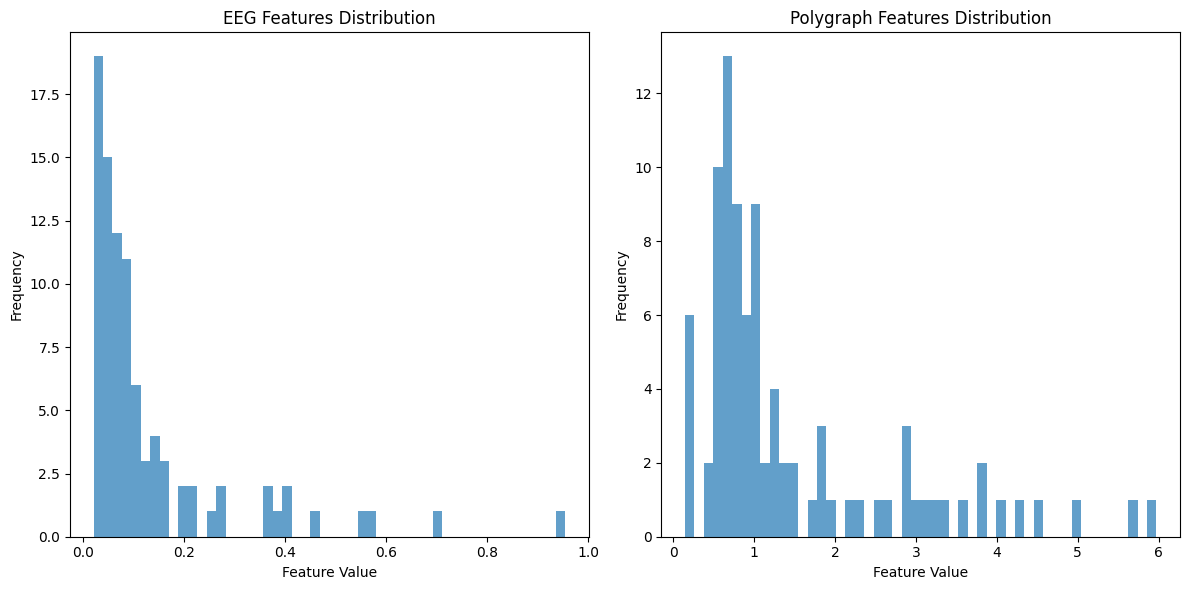

Sample EEG Feature:
[0.0412252]
Label: False

Sample Polygraph Feature:
[0.15194485]
Label: False
EEG Feature - Mean: 0.13179573561124222, Std: 0.15847363061115813
Polygraph Feature - Mean: 1.4648502938747343, Std: 1.2904342925370582


In [111]:
import matplotlib.pyplot as plt

def verify_new_features(new_data):
    # Feature 시각화
    eeg_features = [item[0]['data'] for item in new_data['eeg']]
    poly_features = [item[0]['data'] for item in new_data['poly']]

    # 히스토그램 그리기
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.hist(np.array(eeg_features).flatten(), bins=50, alpha=0.7, label='EEG')
    plt.title('EEG Features Distribution')
    plt.xlabel('Feature Value')
    plt.ylabel('Frequency')

    plt.subplot(1, 2, 2)
    plt.hist(np.array(poly_features).flatten(), bins=50, alpha=0.7, label='Polygraph')
    plt.title('Polygraph Features Distribution')
    plt.xlabel('Feature Value')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

    # 샘플 데이터 확인
    print("Sample EEG Feature:")
    print(new_data['eeg'][0][0]['data'])
    print("Label:", new_data['eeg'][0][1])

    print("\nSample Polygraph Feature:")
    print(new_data['poly'][0][0]['data'])
    print("Label:", new_data['poly'][0][1])

    # Feature 통계 분석
    eeg_mean = np.mean(np.array(eeg_features).flatten())
    eeg_std = np.std(np.array(eeg_features).flatten())
    poly_mean = np.mean(np.array(poly_features).flatten())
    poly_std = np.std(np.array(poly_features).flatten())

    print(f"EEG Feature - Mean: {eeg_mean}, Std: {eeg_std}")
    print(f"Polygraph Feature - Mean: {poly_mean}, Std: {poly_std}")

# 새로운 feature 검증
verify_new_features(new_data_dtw)


EEG t-test: t-statistic = 3.246331915340572, p-value = 0.0016545698154107763
Polygraph t-test: t-statistic = 4.8817547441882265, p-value = 4.658755281829332e-06


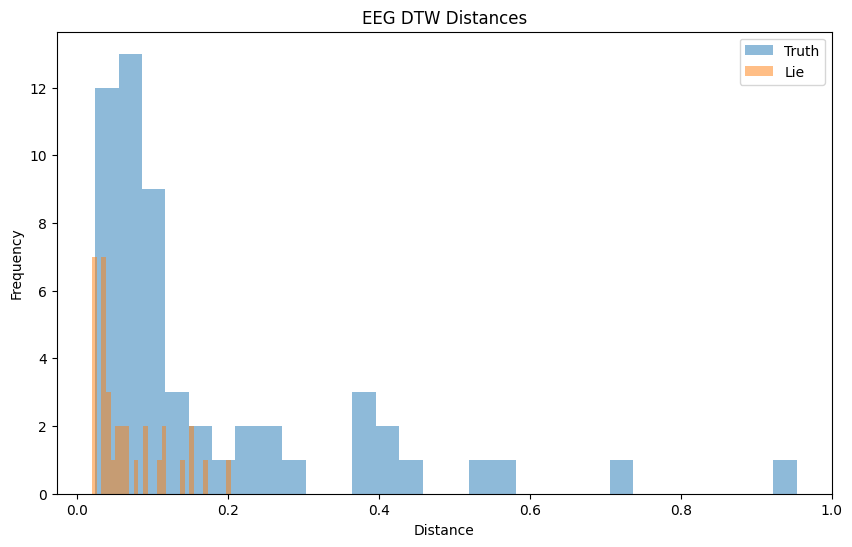

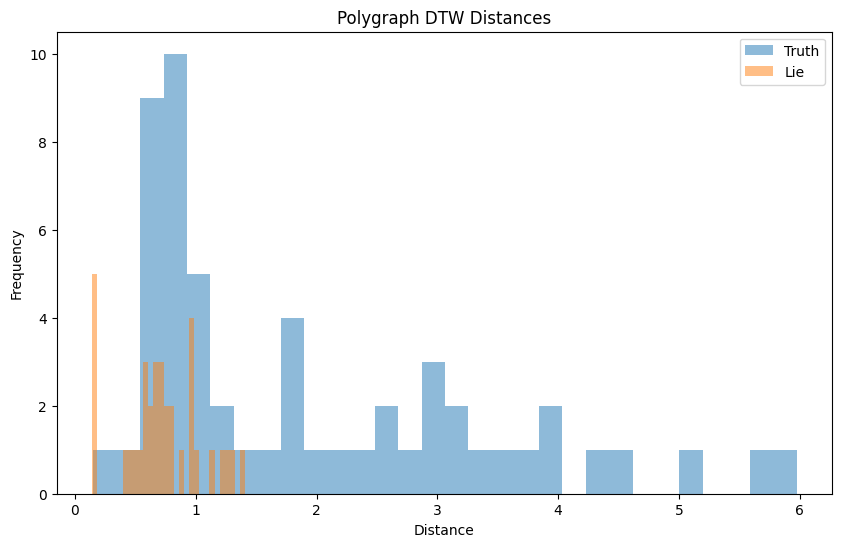

In [112]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

# 라벨별로 거리를 분리
def split_by_label(data):
    truth_distances = []
    lie_distances = []
    for sample in data:
        distance = sample[0]['data'][0]
        label = sample[1]
        if label:
            truth_distances.append(distance)
        else:
            lie_distances.append(distance)
    return truth_distances, lie_distances

# 라벨에 따라 거리 분리
eeg_truth_distances, eeg_lie_distances = split_by_label(new_data_dtw['eeg'])
poly_truth_distances, poly_lie_distances = split_by_label(new_data_dtw['poly'])

# t-test 수행
eeg_t_stat, eeg_p_value = stats.ttest_ind(eeg_truth_distances, eeg_lie_distances)
poly_t_stat, poly_p_value = stats.ttest_ind(poly_truth_distances, poly_lie_distances)

# t-test 결과 출력
print(f"EEG t-test: t-statistic = {eeg_t_stat}, p-value = {eeg_p_value}")
print(f"Polygraph t-test: t-statistic = {poly_t_stat}, p-value = {poly_p_value}")

# 시각화
def plot_distances(truth_distances, lie_distances, title):
    plt.figure(figsize=(10, 6))
    plt.hist(truth_distances, bins=30, alpha=0.5, label='Truth')
    plt.hist(lie_distances, bins=30, alpha=0.5, label='Lie')
    plt.title(title)
    plt.xlabel('Distance')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

# 시각화 출력
plot_distances(eeg_truth_distances, eeg_lie_distances, 'EEG DTW Distances')
plot_distances(poly_truth_distances, poly_lie_distances, 'Polygraph DTW Distances')


In [195]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# 거리 값과 라벨을 사용하여 데이터 준비
def prepare_data(data):
    distances = []
    labels = []
    for sample in data:
        distances.append(sample[0]['data'][0])
        labels.append(1 if sample[1] else 0)
    return np.array(distances).reshape(-1, 1), np.array(labels)

# 데이터 준비
eeg_distances, eeg_labels = prepare_data(new_data_dtw['eeg'])
poly_distances, poly_labels = prepare_data(new_data_dtw['poly'])

# 데이터 분할 (훈련 세트와 테스트 세트)
eeg_train_X, eeg_test_X, eeg_train_y, eeg_test_y = train_test_split(eeg_distances, eeg_labels, test_size=0.2)
poly_train_X, poly_test_X, poly_train_y, poly_test_y = train_test_split(poly_distances, poly_labels, test_size=0.2)

# 로지스틱 회귀 모델 훈련
eeg_model = LogisticRegression()
poly_model = LogisticRegression()

eeg_model.fit(eeg_train_X, eeg_train_y)
poly_model.fit(poly_train_X, poly_train_y)

# 모델 평가
eeg_predictions = eeg_model.predict(eeg_test_X)
poly_predictions = poly_model.predict(poly_test_X)

print("EEG Classification Report:")
print(classification_report(eeg_test_y, eeg_predictions))
print("EEG Confusion Matrix:")
print(confusion_matrix(eeg_test_y, eeg_predictions))

print("\nPolygraph Classification Report:")
print(classification_report(poly_test_y, poly_predictions))
print("Polygraph Confusion Matrix:")
print(confusion_matrix(poly_test_y, poly_predictions))


EEG Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.67      1.00      0.80        12

    accuracy                           0.67        18
   macro avg       0.33      0.50      0.40        18
weighted avg       0.44      0.67      0.53        18

EEG Confusion Matrix:
[[ 0  6]
 [ 0 12]]

Polygraph Classification Report:
              precision    recall  f1-score   support

           0       0.36      1.00      0.53         4
           1       1.00      0.50      0.67        14

    accuracy                           0.61        18
   macro avg       0.68      0.75      0.60        18
weighted avg       0.86      0.61      0.64        18

Polygraph Confusion Matrix:
[[4 0]
 [7 7]]


C:\Users\User\anaconda3\envs\torch_ev\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\User\anaconda3\envs\torch_ev\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\User\anaconda3\envs\torch_ev\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [66]:
import os
import pickle
import random
import numpy as np
import torch
from torch.utils.data import Dataset
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
import matplotlib.pyplot as plt

# 데이터 로드 함수
def load_data(data_path):
    data = {}
    for file_name in os.listdir(data_path):
        if file_name.endswith('.pkl'):
            with open(os.path.join(data_path, file_name), 'rb') as file:
                data[file_name] = pickle.load(file)
    return data

# 피험자 ID 추출 함수
def extract_subject_ids(data):
    truth_subjects = set()
    lie_subjects = set()

    for name in data.keys():
        parts = name.split('_')
        if len(parts) >= 5:
            subject_id = parts[4].replace('.pkl', '')
        elif len(parts) == 4:
            subject_id = parts[3].replace('.pkl', '')
        else:
            continue
        
        if 'truth' in name:
            truth_subjects.add(subject_id)
        elif 'lie' in name:
            lie_subjects.add(subject_id)

    # 진실 ID에서 거짓 ID 제거
    truth_subjects = [subj for subj in truth_subjects if subj not in lie_subjects]
    
    return truth_subjects, list(lie_subjects)

# 4명의 피험자 랜덤 추출 함수 (2명 진실, 2명 거짓)
def select_random_subjects(truth_subjects, lie_subjects, num_each=2):
    if len(truth_subjects) < num_each or len(lie_subjects) < num_each:
        raise ValueError("Not enough subjects in one of the groups to select the required number of samples.")
    
    test_truth_subjects = random.sample(truth_subjects, num_each)
    test_lie_subjects = random.sample(lie_subjects, num_each)
    
    train_truth_subjects = [subj for subj in truth_subjects if subj not in test_truth_subjects]
    train_lie_subjects = [subj for subj in lie_subjects if subj not in test_lie_subjects]
    
    return test_truth_subjects, test_lie_subjects, train_truth_subjects, train_lie_subjects

# 특징 추출 함수
def create_new_features_dtw(data, subject_ids):
    new_data = {'poly': []}

    for key, value in data.items():
        parts = key.split('_')
        if len(parts) >= 5:
            subject_id = parts[4].replace('.pkl', '')
        elif len(parts) == 4:
            subject_id = parts[3].replace('.pkl', '')
        else:
            continue

        if subject_id not in subject_ids:
            continue

        if 'ansc' in key and 'poly' in key:
            ansc_data = value
            for sample_key, sample_value in data.items():
                if subject_id in sample_key and 'poly' in sample_key and ('ansr_truth' in sample_key or 'ansr_lie' in sample_key):
                    for i in range(len(sample_value)):
                        sample_seq = sample_value[i]
                        ansc_seq = ansc_data[i]

                        distance, path = fastdtw(sample_seq, ansc_seq, dist=euclidean)
                        new_feature = np.array([distance])

                        new_data['poly'].append(({'data': new_feature, 'subject_id': subject_id}, 'truth' in sample_key))

    return new_data

# PyTorch Dataset 정의
class PolyDataset(Dataset):
    def __init__(self, data):
        self.data = []
        for sample_dict, label in data['poly']:
            self.data.append((sample_dict['data'], label, sample_dict['subject_id']))
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        sample, label, subject_id = self.data[idx]
        return torch.tensor(sample, dtype=torch.float32), torch.tensor(label, dtype=torch.float32), subject_id

# 학습 및 평가 함수
def train_and_evaluate(train_truth_subjects, train_lie_subjects, test_truth_subjects, test_lie_subjects, data):
    train_data = create_new_features_dtw(data, train_truth_subjects + train_lie_subjects)
    test_data = create_new_features_dtw(data, test_truth_subjects + test_lie_subjects)

    train_dataset = PolyDataset(train_data)
    test_dataset = PolyDataset(test_data)
    
    X_train = [train_dataset[i][0].item() for i in range(len(train_dataset))]
    y_train = [train_dataset[i][1].item() for i in range(len(train_dataset))]
    
    X_test = [test_dataset[i][0].item() for i in range(len(test_dataset))]
    y_test = [test_dataset[i][1].item() for i in range(len(test_dataset))]
    subject_ids = [test_dataset[i][2] for i in range(len(test_dataset))]
    
    model = LogisticRegression()
    model.fit(np.array(X_train).reshape(-1, 1), y_train)
    
    y_pred = model.predict(np.array(X_test).reshape(-1, 1))
    
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    results = {'y_true': y_test, 'y_pred': y_pred, 'accuracy': accuracy, 'f1_score': f1, 'subject_ids': subject_ids}
    return results

# 메인 실행 함수
def main(data_path, num_repeats=10):
    data = load_data(data_path)
    truth_subjects, lie_subjects = extract_subject_ids(data)
    
    if len(truth_subjects) < 2 or len(lie_subjects) < 2:
        raise ValueError("Not enough subjects in one of the groups to perform the test.")
    
    accuracies = []
    f1_scores = []
    all_results = []
    
    for run_idx in range(num_repeats):
        try:
            test_truth_subjects, test_lie_subjects, train_truth_subjects, train_lie_subjects = select_random_subjects(truth_subjects, lie_subjects)
            results = train_and_evaluate(train_truth_subjects, train_lie_subjects, test_truth_subjects, test_lie_subjects, data)
            accuracies.append(results['accuracy'])
            f1_scores.append(results['f1_score'])
            all_results.append(results)
            
            # 세부 결과 출력
            print(f"Run {run_idx+1}:")
            for subj_id, y_t, y_p in zip(results['subject_ids'], results['y_true'], results['y_pred']):
                print(f"Subject ID: {subj_id}, True: {'Truth' if y_t else 'Lie'}, Predicted: {'Truth' if y_p else 'Lie'}")
            print(f"Accuracy: {results['accuracy']}, F1 Score: {results['f1_score']}\n")
            
        except ValueError as e:
            print(f"Skipping this iteration due to error: {e}")
    
    if accuracies:
        avg_accuracy = np.mean(accuracies)
        avg_f1_score = np.mean(f1_scores)
        print(f'Average Accuracy over {num_repeats} runs: {avg_accuracy}')
        print(f'Average F1 Score over {num_repeats} runs: {avg_f1_score}')
             
    else:
        print("Not enough data to perform the test.")

if __name__ == "__main__":
    main("D:/Dropbox/거짓말탐지기/거탐 코드/분석코드 모음/모의범죄 분석 코드/npy 데이터")


Run 1:
Subject ID: 05, True: Lie, Predicted: Lie
Subject ID: 05, True: Lie, Predicted: Lie
Subject ID: 05, True: Lie, Predicted: Lie
Subject ID: 05, True: Lie, Predicted: Lie
Subject ID: 05, True: Lie, Predicted: Lie
Subject ID: 05, True: Truth, Predicted: Lie
Subject ID: 09, True: Truth, Predicted: Truth
Subject ID: 09, True: Truth, Predicted: Lie
Subject ID: 09, True: Truth, Predicted: Lie
Subject ID: 09, True: Truth, Predicted: Lie
Subject ID: 09, True: Truth, Predicted: Lie
Subject ID: 09, True: Truth, Predicted: Lie
Subject ID: 12, True: Truth, Predicted: Lie
Subject ID: 12, True: Truth, Predicted: Lie
Subject ID: 12, True: Truth, Predicted: Lie
Subject ID: 12, True: Truth, Predicted: Lie
Subject ID: 12, True: Truth, Predicted: Truth
Subject ID: 12, True: Truth, Predicted: Truth
Subject ID: 13, True: Lie, Predicted: Lie
Subject ID: 13, True: Lie, Predicted: Lie
Subject ID: 13, True: Lie, Predicted: Lie
Subject ID: 13, True: Lie, Predicted: Truth
Subject ID: 13, True: Lie, Predicte

# 다른 feature 찾기

In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy.interpolate import interp1d
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean

def interpolate_sequence(seq, target_length):
    """ 시퀀스를 보간하여 target_length로 변환 """
    original_length = seq.shape[1]
    interpolator = interp1d(np.arange(original_length), seq, axis=1, kind='linear', fill_value='extrapolate')
    interpolated_seq = interpolator(np.linspace(0, original_length - 1, target_length))
    return interpolated_seq

def create_new_features_dtw(data):
    new_data = {'eeg': [], 'poly': []}
    scaler = StandardScaler()

    for key, value in data.items():
        parts = key.split('_')
        if len(parts) >= 5:
            subject_id = parts[4].replace('.pkl', '')
        elif len(parts) == 4:
            subject_id = parts[3].replace('.pkl', '')
        else:
            continue

        if 'quec' in key and 'eeg' in key:
            quec_data = value
            for sample_key, sample_value in data.items():
                if subject_id in sample_key and 'eeg' in sample_key and ('quer_truth' in sample_key or 'quer_lie' in sample_key):
                    for i in range(len(sample_value)):
                        # 보간을 사용하여 길이 맞추기
                        sample_seq = sample_value[i]
                        quec_seq = quec_data[i]

                        target_length = max(sample_seq.shape[1], quec_seq.shape[1])
                        sample_seq_interpolated = interpolate_sequence(sample_seq, target_length)
                        quec_seq_interpolated = interpolate_sequence(quec_seq, target_length)

                        # 중간 결과 출력: 보간된 시퀀스 확인
                        print(f"Sample Seq Interpolated (EEG): {sample_seq_interpolated.shape}")
                        print(f"Quec Seq Interpolated (EEG): {quec_seq_interpolated.shape}")

                        distance, path = fastdtw(sample_seq_interpolated, quec_seq_interpolated, dist=euclidean)
                        new_feature = np.array([distance])
                        scaled_feature = scaler.fit_transform(new_feature.reshape(-1, 1)).reshape(1, -1)

                        # 중간 결과 출력: DTW 거리와 스케일링된 특징 확인
                        print(f"DTW Distance (EEG): {distance}")
                        print(f"Scaled Feature (EEG): {scaled_feature}")

                        new_data['eeg'].append(({'data': scaled_feature, 'subject_id': subject_id}, 'truth' in sample_key))

        if 'ansc' in key and 'poly' in key:
            ansc_data = value
            for sample_key, sample_value in data.items():
                if subject_id in sample_key and 'poly' in sample_key and ('ansr_truth' in sample_key or 'ansr_lie' in sample_key):
                    for i in range(len(sample_value)):
                        # 보간을 사용하여 길이 맞추기
                        sample_seq = sample_value[i]
                        ansc_seq = ansc_data[i]

                        target_length = max(sample_seq.shape[1], ansc_seq.shape[1])
                        sample_seq_interpolated = interpolate_sequence(sample_seq, target_length)
                        ansc_seq_interpolated = interpolate_sequence(ansc_seq, target_length)

                        # 중간 결과 출력: 보간된 시퀀스 확인
                        print(f"Sample Seq Interpolated (Poly): {sample_seq_interpolated.shape}")
                        print(f"Ansc Seq Interpolated (Poly): {ansc_seq_interpolated.shape}")

                        new_feature = np.abs(sample_seq_interpolated - ansc_seq_interpolated)

                        # 중간 결과 출력: 생성된 특징 확인
                        print(f"New Feature (Poly): {new_feature.shape}")

                        scaled_feature = scaler.fit_transform(new_feature.T).T
                        new_data['poly'].append(({'data': scaled_feature, 'subject_id': subject_id}, 'truth' in sample_key))

    return new_data

new_data_dtw = create_new_features_dtw(data)

# 생성된 새로운 feature를 확인하기 위한 코드
for key, value in new_data_dtw.items():
    print(f"Key: {key}, Number of samples: {len(value)}")
    if len(value) > 0:
        print(f"First sample data shape: {value[0][0]['data'].shape}, Label: {value[0][1]}")

# 통합모델

In [63]:
import numpy as np
import os
import pickle
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean

# Define EEGNet model
class EEGNet(nn.Module):
    def __init__(self, num_classes, channels=64, samples=128, dropout_rate=0.5, kernel_length=64, F1=8, D=2, F2=16, norm_rate=0.25):
        super(EEGNet, self).__init__()
        self.num_classes = num_classes
        self.channels = channels
        self.samples = samples
        self.dropout_rate = dropout_rate
        self.kernel_length = kernel_length
        self.F1 = F1
        self.D = D
        self.F2 = F2
        self.norm_rate = norm_rate

        self.firstconv = nn.Sequential(
            nn.Conv2d(1, self.F1, (1, self.kernel_length), padding=(0, self.kernel_length // 2), bias=False),
            nn.BatchNorm2d(self.F1)
        )

        self.depthwiseConv = nn.Sequential(
            nn.Conv2d(self.F1, self.F1 * self.D, (self.channels, 1), groups=self.F1, bias=False),
            nn.BatchNorm2d(self.F1 * self.D),
            nn.ELU(),
            nn.AvgPool2d((1, 4)),
            nn.Dropout(self.dropout_rate)
        )

        self.separableConv = nn.Sequential(
            nn.Conv2d(self.F1 * self.D, self.F2, (1, 16), padding=(0, 8), bias=False),
            nn.BatchNorm2d(self.F2),
            nn.ELU(),
            nn.AvgPool2d((1, 8)),
            nn.Dropout(self.dropout_rate)
        )

        self.classify = None  # Linear layer will be defined in the forward method based on the input size

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.firstconv(x)
        x = self.depthwiseConv(x)
        x = self.separableConv(x)
        x = x.view(x.size(0), -1)
        if self.classify is None:
            self.classify = nn.Linear(x.size(1), self.num_classes).to(x.device)
        x = self.classify(x)
        return torch.sigmoid(x)

# Functions to load and process data
def load_data(data_path):
    data = {}
    for file_name in os.listdir(data_path):
        if file_name.endswith('.pkl'):
            with open(os.path.join(data_path, file_name), 'rb') as file:
                data[file_name] = pickle.load(file)
    return data
    

def extract_subject_ids(data):
    truth_subjects = set()
    lie_subjects = set()

    for name in data.keys():
        parts = name.split('_')
        if len(parts) >= 5:
            subject_id = parts[4].replace('.pkl', '')
        elif len(parts) == 4:
            subject_id = parts[3].replace('.pkl', '')
        else:
            continue
        
        if 'truth' in name:
            truth_subjects.add(subject_id)
        elif 'lie' in name:
            lie_subjects.add(subject_id)

    truth_subjects = [subj for subj in truth_subjects if subj not in lie_subjects]
    
    return truth_subjects, list(lie_subjects)
    

def select_random_subjects(truth_subjects, lie_subjects, num_each=2):
    if len(truth_subjects) < num_each or len(lie_subjects) < num_each:
        raise ValueError("Not enough subjects in one of the groups to select the required number of samples.")
    
    test_truth_subjects = random.sample(truth_subjects, num_each)
    test_lie_subjects = random.sample(lie_subjects, num_each)
    
    train_truth_subjects = [subj for subj in truth_subjects if subj not in test_truth_subjects]
    train_lie_subjects = [subj for subj in lie_subjects if subj not in test_lie_subjects]
    
    return test_truth_subjects, test_lie_subjects, train_truth_subjects, train_lie_subjects

def split_data(data, test_truth_subjects, test_lie_subjects):
    train_data = {'eeg': []}
    test_data = {'eeg': []}

    for key, value in data.items():
        parts = key.split('_')
        if len(parts) >= 5:
            subject_id = parts[4].replace('.pkl', '')
        elif len(parts) == 4:
            subject_id = parts[3].replace('.pkl', '')
        else:
            continue

        for sample in value:
            sample_data = {'data': sample, 'subject_id': subject_id}

            if subject_id in test_truth_subjects or subject_id in test_lie_subjects:
                if 'eeg' in key and ('quer_truth' in key or 'quer_lie' in key):
                    test_data['eeg'].append((sample_data, 'truth' in key))
            else:
                if 'eeg' in key and ('quer_truth' in key or 'quer_lie' in key):
                    train_data['eeg'].append((sample_data, 'truth' in key))

    return train_data, test_data

def collate_fn(batch):
    max_len = 2500
    data, labels, subject_ids = zip(*batch)
    data = [d.transpose(0, 1) for d in data]
    data_padded = pad_sequence(data, batch_first=True, padding_value=0)

    if data_padded.size(1) > max_len:
        data_padded = data_padded[:, :max_len, :]
    else:
        pad_size = max_len - data_padded.size(1)
        data_padded = torch.nn.functional.pad(data_padded, (0, 0, 0, pad_size))

    return data_padded, torch.tensor(labels), torch.tensor([d.size(1) for d in data]), list(subject_ids)

class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample, label = self.data[idx]
        data, subject_id = sample['data'], sample['subject_id']
        label = 1 if label else 0
        return torch.tensor(data, dtype=torch.float32), torch.tensor(label, dtype=torch.float32), subject_id

# Training and prediction functions for EEG model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def train_model(model, train_loader, optimizer, criterion, num_epochs=100):
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)
    best_loss = float('inf')

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels, lengths, subject_ids in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        scheduler.step(running_loss / len(train_loader))
        print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {running_loss/len(train_loader)}")

def ensemble_predict(model, eeg_loader):
    model.eval()
    all_predictions = {}
    with torch.no_grad():
        for eeg_inputs, eeg_labels, eeg_lengths, eeg_subject_ids in eeg_loader:
            eeg_inputs = eeg_inputs.to(device)

            eeg_outputs = model(eeg_inputs)

            predictions = (eeg_outputs > 0.5).float()

            for subject_id, prediction in zip(eeg_subject_ids, predictions):
                if subject_id not in all_predictions:
                    all_predictions[subject_id] = []
                all_predictions[subject_id].append(prediction.item())

    final_predictions = {}
    for subject_id, preds in all_predictions.items():
        avg_prediction = np.mean(preds)
        final_predictions[subject_id] = 'Truth' if avg_prediction >= 0.5 else 'Lie'

    return final_predictions

# Define polygraph model functions
def create_new_features_dtw(data, subject_ids):
    new_data = {'poly': []}

    for key, value in data.items():
        parts = key.split('_')
        if len(parts) >= 5:
            subject_id = parts[4].replace('.pkl', '')
        elif len(parts) == 4:
            subject_id = parts[3].replace('.pkl', '')
        else:
            continue

        if subject_id not in subject_ids:
            continue

        if 'ansc' in key and 'poly' in key:
            ansc_data = value
            for sample_key, sample_value in data.items():
                if subject_id in sample_key and 'poly' in sample_key and ('ansr_truth' in sample_key or 'ansr_lie' in sample_key):
                    for i in range(len(sample_value)):
                        sample_seq = sample_value[i]
                        ansc_seq = ansc_data[i]

                        distance, path = fastdtw(sample_seq, ansc_seq, dist=euclidean)
                        new_feature = np.array([distance])

                        new_data['poly'].append(({'data': new_feature, 'subject_id': subject_id}, 'truth' in sample_key))

    return new_data

class PolyDataset(Dataset):
    def __init__(self, data):
        self.data = []
        for sample_dict, label in data['poly']:
            self.data.append((sample_dict['data'], label, sample_dict['subject_id']))
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        sample, label, subject_id = self.data[idx]
        return torch.tensor(sample, dtype=torch.float32), torch.tensor(label, dtype=torch.float32), subject_id

def train_and_evaluate(train_truth_subjects, train_lie_subjects, test_truth_subjects, test_lie_subjects, data):
    train_data = create_new_features_dtw(data, train_truth_subjects + train_lie_subjects)
    test_data = create_new_features_dtw(data, test_truth_subjects + test_lie_subjects)

    train_dataset = PolyDataset(train_data)
    test_dataset = PolyDataset(test_data)
    
    X_train = [train_dataset[i][0].item() for i in range(len(train_dataset))]
    y_train = [train_dataset[i][1].item() for i in range(len(train_dataset))]
    
    X_test = [test_dataset[i][0].item() for i in range(len(test_dataset))]
    y_test = [test_dataset[i][1].item() for i in range(len(test_dataset))]
    subject_ids = [test_dataset[i][2] for i in range(len(test_dataset))]
    
    model = LogisticRegression()
    model.fit(np.array(X_train).reshape(-1, 1), y_train)
    
    y_pred = model.predict(np.array(X_test).reshape(-1, 1))
    
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    results = {'y_true': y_test, 'y_pred': y_pred, 'accuracy': accuracy, 'f1_score': f1, 'subject_ids': subject_ids}
    return results

# Function to evaluate combined model
def evaluate_combined(predictions_eeg, predictions_poly, true_labels):
    combined_predictions = {}
    for subject_id in true_labels.keys():
        votes = [predictions_eeg.get(subject_id), predictions_poly.get(subject_id)]
        combined_predictions[subject_id] = 'Truth' if votes.count('Truth') > votes.count('Lie') else 'Lie'

    true_vals = []
    pred_vals = []
    
    print("\nDetailed Results:")
    print("Subject ID | EEG Prediction | Polygraph Prediction | Combined Prediction | True Label")
    print("-----------|----------------|----------------------|---------------------|-----------")

    for subject_id in true_labels.keys():
        true_val = 1 if true_labels[subject_id] == 'Truth' else 0
        pred_val = 1 if combined_predictions[subject_id] == 'Truth' else 0
        true_vals.append(true_val)
        pred_vals.append(pred_val)
        
        print(f"{subject_id:<10} | {predictions_eeg.get(subject_id):<14} | {predictions_poly.get(subject_id):<20} | {combined_predictions[subject_id]:<19} | {true_labels[subject_id]}")

    accuracy = accuracy_score(true_vals, pred_vals)
    precision = precision_score(true_vals, pred_vals)
    recall = recall_score(true_vals, pred_vals)
    f1 = f1_score(true_vals, pred_vals)
    
    print(f"\nCombined Model Accuracy: {accuracy:.4f}")
    print(f"Combined Model Precision: {precision:.4f}")
    print(f"Combined Model Recall: {recall:.4f}")
    print(f"Combined Model F1 Score: {f1:.4f}")
    
    return accuracy, precision, recall, f1

# Main function with additional verification steps
def main(data_path, num_repeats=100):
    data = load_data(data_path)
    print(f"Loaded {len(data)} data files.")
    truth_subjects, lie_subjects = extract_subject_ids(data)
    print(f"Extracted {len(truth_subjects)} truth subjects and {len(lie_subjects)} lie subjects.")
    accuracies = []
    precisions = []
    recalls = []
    f1_scores = []

    for i in range(num_repeats):
        test_truth_subjects, test_lie_subjects, train_truth_subjects, train_lie_subjects = select_random_subjects(truth_subjects, lie_subjects)
        print(f"Run {i+1}: Selected {len(test_truth_subjects)} test truth subjects and {len(test_lie_subjects)} test lie subjects.")
        train_data, test_data = split_data(data, test_truth_subjects, test_lie_subjects)

        # Train EEG model
        train_eeg_loader = DataLoader(CustomDataset(train_data['eeg']), batch_size=8, shuffle=True, collate_fn=collate_fn)
        test_eeg_loader = DataLoader(CustomDataset(test_data['eeg']), batch_size=8, shuffle=False, collate_fn=collate_fn)

        eeg_model = EEGNet(num_classes=1, channels=65, samples=2500)
        eeg_model.to(device)

        eeg_optimizer = optim.Adam(eeg_model.parameters(), lr=0.001)
        criterion = nn.BCELoss()

        print(f"Training EEG model for run {i+1}...")
        train_model(eeg_model, train_eeg_loader, eeg_optimizer, criterion, num_epochs=50)

        predictions_eeg = ensemble_predict(eeg_model, test_eeg_loader)
        print(f"EEG model predictions for run {i+1}: {predictions_eeg}")

        # Train polygraph model
        results_poly = train_and_evaluate(train_truth_subjects, train_lie_subjects, test_truth_subjects, test_lie_subjects, data)
        predictions_poly = {
            subj: 'Truth' if pred else 'Lie' for subj, pred in zip(results_poly['subject_ids'], results_poly['y_pred'])
        }
        print(f"Polygraph model predictions for run {i+1}: {predictions_poly}")

        true_labels = {
            subj: 'Truth' for subj in test_truth_subjects
        }
        true_labels.update({
            subj: 'Lie' for subj in test_lie_subjects
        })

        accuracy, precision, recall, f1 = evaluate_combined(predictions_eeg, predictions_poly, true_labels)
        accuracies.append(accuracy)
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)

    print(f"Average Combined Model Accuracy over {num_repeats} runs: {np.mean(accuracies):.4f}")
    print(f"Average Combined Model Precision over {num_repeats} runs: {np.mean(precisions):.4f}")
    print(f"Average Combined Model Recall over {num_repeats} runs: {np.mean(recalls):.4f}")
    print(f"Average Combined Model F1 Score over {num_repeats} runs: {np.mean(f1_scores):.4f}")

if __name__ == "__main__":
    main("D:/Dropbox/거짓말탐지기/거탐 코드/분석코드 모음/모의범죄 분석 코드/npy 데이터")


Loaded 208 data files.
Extracted 8 truth subjects and 7 lie subjects.
Run 1: Selected 2 test truth subjects and 2 test lie subjects.
Training EEG model for run 1...
Epoch 1/50, Training Loss: 0.6951615942849053
Epoch 2/50, Training Loss: 0.7015571196873983
Epoch 3/50, Training Loss: 0.6164478328492906
Epoch 4/50, Training Loss: 0.5872416430049472
Epoch 5/50, Training Loss: 0.6096147100130717
Epoch 6/50, Training Loss: 0.5438832408852048
Epoch 7/50, Training Loss: 0.5590821140342288
Epoch 8/50, Training Loss: 0.5296617911921607
Epoch 9/50, Training Loss: 0.5189144114653269
Epoch 10/50, Training Loss: 0.5259136193328433
Epoch 11/50, Training Loss: 0.5440110398663415
Epoch 12/50, Training Loss: 0.4953279130988651
Epoch 13/50, Training Loss: 0.5363906588819292
Epoch 14/50, Training Loss: 0.519270165099038
Epoch 15/50, Training Loss: 0.4948001768853929
Epoch 16/50, Training Loss: 0.49703815910551286
Epoch 17/50, Training Loss: 0.4896829393174913
Epoch 18/50, Training Loss: 0.458534293704562

C:\Users\User\anaconda3\envs\torch_ev\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/50, Training Loss: 0.6924356553289626
Epoch 2/50, Training Loss: 0.6331056157747904
Epoch 3/50, Training Loss: 0.6111310124397278
Epoch 4/50, Training Loss: 0.6049443946944343
Epoch 5/50, Training Loss: 0.6050768362151252
Epoch 6/50, Training Loss: 0.5517415404319763
Epoch 7/50, Training Loss: 0.5403785639339023
Epoch 8/50, Training Loss: 0.5413598517576853
Epoch 9/50, Training Loss: 0.5189976294835409
Epoch 10/50, Training Loss: 0.5270483560032315
Epoch 11/50, Training Loss: 0.5140374236636691
Epoch 12/50, Training Loss: 0.5324132376246982
Epoch 13/50, Training Loss: 0.519499252239863
Epoch 14/50, Training Loss: 0.5194508698251512
Epoch 15/50, Training Loss: 0.4917366107304891
Epoch 16/50, Training Loss: 0.4891183276971181
Epoch 17/50, Training Loss: 0.477742248111301
Epoch 18/50, Training Loss: 0.5315591593583425
Epoch 19/50, Training Loss: 0.5210484663645426
Epoch 20/50, Training Loss: 0.46645551257663304
Epoch 21/50, Training Loss: 0.4710795382658641
Epoch 22/50, Training L

C:\Users\User\anaconda3\envs\torch_ev\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# 3세트 전처리

In [74]:
import os
import pandas as pd
import numpy as np
import mne
from mne.preprocessing import ICA, create_ecg_epochs, create_eog_epochs
from mne.filter import filter_data, notch_filter
import pickle

# 경로 설정
eeg_data_path = r"D:\Dropbox\거짓말탐지기\EEG + Eyetracker + polygraph\모의범죄 실험 데이터\EEG 데이터"
code_data_path = r'D:/Dropbox/거짓말탐지기/EEG + Eyetracker + polygraph/모의범죄 실험 데이터/행동 데이터/data'
output_data_path = r'D:\Dropbox\거짓말탐지기\거탐 코드\분석코드 모음\모의범죄 분석 코드\3set_pkl'

# 피험자 파일 리스트
eeg_files = [f for f in os.listdir(eeg_data_path) if f.endswith('.mff')]
print(f"총 {len(eeg_files)}개의 EEG 파일을 발견했습니다.")

# 통합 데이터를 저장할 리스트 초기화
combined_eeg_data = {}
combined_poly_data = {}

def save_epochs(epochs_data, epoch_labels, data_type, participant_number, combined_data):
    labels = set(epoch_labels)
    for label in labels:
        label_indices = [i for i, l in enumerate(epoch_labels) if l == label]
        label_data = [epochs_data[i] for i in label_indices]
        
        # 개별 피험자 데이터 저장
        with open(os.path.join(output_data_path, f"{data_type}_{label}_{participant_number}.pkl"), 'wb') as f:
            pickle.dump(label_data, f)
        
        # 통합 데이터 업데이트
        if label not in combined_data:
            combined_data[label] = label_data
        else:
            combined_data[label].extend(label_data)
    
    print(f"{participant_number}의 {data_type} 데이터가 저장되었습니다.")

def preprocess_and_save_poly(raw_poly, events, event_labels, participant_number):
    # EDA 채널 전처리 (0.5~15 Hz, 60 Hz 노치 필터)
    eda_channel = mne.pick_channels(raw_poly.info['ch_names'], include=['EDA'])
    raw_poly._data[eda_channel, :] = filter_data(raw_poly._data[eda_channel, :], raw_poly.info['sfreq'], l_freq=0.5, h_freq=15, method='fir', fir_design='firwin')
    raw_poly._data[eda_channel, :] = notch_filter(raw_poly._data[eda_channel, :], raw_poly.info['sfreq'], freqs=60, method='fir', fir_design='firwin')

    # PPG 채널 전처리 (0.01~15 Hz, 60 Hz 노치 필터)
    ppg_channel = mne.pick_channels(raw_poly.info['ch_names'], include=['PPG'])
    raw_poly._data[ppg_channel, :] = filter_data(raw_poly._data[ppg_channel, :], raw_poly.info['sfreq'], l_freq=0.01, h_freq=15, method='fir', fir_design='firwin')
    raw_poly._data[ppg_channel, :] = notch_filter(raw_poly._data[ppg_channel, :], raw_poly.info['sfreq'], freqs=60, method='fir', fir_design='firwin')

    # Resp. Effort 채널 전처리 (1~15 Hz, 60 Hz 노치 필터)
    resp_channel = mne.pick_channels(raw_poly.info['ch_names'], include=['Resp. Effort'])
    raw_poly._data[resp_channel, :] = filter_data(raw_poly._data[resp_channel, :], raw_poly.info['sfreq'], l_freq=1, h_freq=15, method='fir', fir_design='firwin')
    raw_poly._data[resp_channel, :] = notch_filter(raw_poly._data[resp_channel, :], raw_poly.info['sfreq'], freqs=60, method='fir', fir_design='firwin')

    # ECG 채널 전처리 (1~70 Hz, 60 Hz 노치 필터)
    ecg_channel = mne.pick_channels(raw_poly.info['ch_names'], include=['ECG'])
    raw_poly._data[ecg_channel, :] = filter_data(raw_poly._data[ecg_channel, :], raw_poly.info['sfreq'], l_freq=1, h_freq=70, method='fir', fir_design='firwin')
    raw_poly._data[ecg_channel, :] = notch_filter(raw_poly._data[ecg_channel, :], raw_poly.info['sfreq'], freqs=60, method='fir', fir_design='firwin')

    # 폴리그래프 데이터 에포킹
    epochs_list = []
    epoch_labels = []
    for i in range(len(events)):
        event_id = events[i][2]
        onset = events[i][0]

        if event_id == 7:  # stim
            try:
                rest_event_index = next(j for j in range(i + 1, len(events)) if events[j][2] == 8)
                end_onset = events[rest_event_index][0]
                epochs_list.append([onset, end_onset])
                epoch_labels.append('stim')
            except StopIteration:
                pass
        elif event_id == 8:  # rest
            end_onset = onset + int(10 * raw_poly.info['sfreq'])
            epochs_list.append([onset, end_onset])
            epoch_labels.append('rest')

    epochs_data = []
    for start, end in epochs_list:
        if end <= len(raw_poly.times):
            epoch_data = raw_poly.get_data(start=start, stop=end)
            epochs_data.append(epoch_data)

    print(f"{participant_number}의 폴리그래프 데이터 에포킹 완료. 총 {len(epochs_data)}개의 에포크")
    save_epochs(epochs_data, epoch_labels, 'poly', participant_number, combined_poly_data)

def process_participant_data(participant_number):    
    eeg_file = next(f for f in eeg_files if participant_number in f)
    file_path = os.path.join(eeg_data_path, eeg_file)
    code_file = next(f for f in os.listdir(code_data_path) if participant_number in f)

    # 데이터 로드
    raw = mne.io.read_raw_egi(file_path, preload=True)
    raw.resample(250)
    print(f"{participant_number}의 EEG 데이터 로드 및 리샘플링 완료")

    # EEG 채널과 폴리그래프 채널 분리
    eeg_channels = mne.pick_types(raw.info, eeg=True, stim=False, bio=False, ecg=False, eog=False)
    bio_channels = mne.pick_types(raw.info, eeg=False, stim=False, bio=True, ecg=True, eog=False)

    print(f"선택된 EEG 채널: {len(eeg_channels)}개, 선택된 Bio 채널: {len(bio_channels)}개")

    # EEG 데이터 전처리
    raw_eeg = raw.copy().pick(eeg_channels)
    raw_eeg.filter(0.1, 50, fir_design='firwin')
    raw_eeg.notch_filter(freqs=[60, 120], fir_design='firwin')
    raw_eeg.set_eeg_reference('average', projection=True)
    raw_eeg.apply_proj()
    print(f"{participant_number}의 EEG 데이터 전처리 완료")

    # ICA to remove ECG and EOG artifacts
    ica = ICA(n_components=15, random_state=97, max_iter=800)
    ica.fit(raw_eeg)

    # ECG 아티팩트를 찾고 제거
    ecg_epochs = create_ecg_epochs(raw, ch_name='ECG')
    ecg_indices, ecg_scores = ica.find_bads_ecg(ecg_epochs, method='correlation', threshold='auto')
    ica.exclude.extend(ecg_indices)

    # EOG 아티팩트를 수동으로 찾고 제거 (E1 채널 사용)
    eog_indices, eog_scores = ica.find_bads_eog(raw_eeg, ch_name='E1')
    ica.exclude.extend(eog_indices)

    # ICA 적용
    ica.apply(raw_eeg)
    print(f"{participant_number}의 ICA 적용 완료")

    # 폴리그래프 데이터 전처리
    raw_poly = raw.copy().pick(bio_channels)

    # 이벤트 마커 추출
    events = mne.find_events(raw)

    # 이벤트 라벨링
    event_labels = []
    for event in events:
        if event[2] == 7:
            event_labels.append('stim')
        elif event[2] == 8:
            event_labels.append('rest')
        else:
            event_labels.append('other')

    print(f"{participant_number}의 이벤트 라벨링 완료. 첫 10개 이벤트:")
    print(event_labels[:10])

    # 에포크 생성
    epochs_list = []
    epoch_labels = []
    for i in range(len(events)):
        event_id = events[i][2]
        onset = events[i][0]

        if event_id == 7:  # stim
            try:
                rest_event_index = next(j for j in range(i + 1, len(events)) if events[j][2] == 8)
                end_onset = events[rest_event_index][0]
                epochs_list.append([onset, end_onset])
                epoch_labels.append('stim')
            except StopIteration:
                pass
        elif event_id == 8:  # rest
            end_onset = onset + int(10 * raw.info['sfreq'])
            epochs_list.append([onset, end_onset])
            epoch_labels.append('rest')

    # 에포크 생성
    epochs_data = []
    for start, end in epochs_list:
        if end <= len(raw_eeg.times):
            epoch_data = raw_eeg.get_data(start=start, stop=end)
            epochs_data.append(epoch_data)
            print(f"Epoch from {start} to {end} with shape: {epoch_data.shape}")

    # EEG 데이터 저장
    save_epochs(epochs_data, epoch_labels, 'eeg', participant_number, combined_eeg_data)

    # 폴리그래프 데이터 저장
    preprocess_and_save_poly(raw_poly, events, event_labels, participant_number)

    print(f"Participant {participant_number} data processing complete.")

# 모든 피험자에 대해 반복 처리
for eeg_file in eeg_files:
    participant_number = "_".join(eeg_file.split('_')[1:3])
    process_participant_data(participant_number)

# 통합 데이터 저장
for label, data in combined_eeg_data.items():
    print(f"Combining EEG data for label {label} with {len(data)} epochs")
    np.save(os.path.join(output_data_path, f"combined_eeg_{label}.npy"), np.array(data, dtype=object))

for label, data in combined_poly_data.items():
    print(f"Combining Poly data for label {label} with {len(data)} epochs")
    np.save(os.path.join(output_data_path, f"combined_poly_{label}.npy"), np.array(data, dtype=object))

print("모든 피험자 데이터 처리가 완료되었습니다.")


총 15개의 EEG 파일을 발견했습니다.
Reading EGI MFF Header from D:\Dropbox\거짓말탐지기\EEG + Eyetracker + polygraph\모의범죄 실험 데이터\EEG 데이터\lie_1_01_20240522_105710.mff...
    Reading events ...
    Assembling measurement info ...
    Synthesizing trigger channel "STI 014" ...
    Excluding events {} ...
Reading 0 ... 215226  =      0.000 ...   430.452 secs...
52 events found on stim channel STI 014
Event IDs: [1 2 3 4 5 6 7 8]
52 events found on stim channel STI 014
Event IDs: [1 2 3 4 5 6 7 8]
1_01의 EEG 데이터 로드 및 리샘플링 완료
선택된 EEG 채널: 65개, 선택된 Bio 채널: 4개
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 50.00 Hz
- Upper trans

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
1_01의 EEG 데이터 전처리 완료
Fitting ICA to data using 65 channels (please be patient, this may take a while)
    Applying projection operator with 1 vector (pre-whitener computation)
    Applying projection operator with 1 vector (pre-whitener application)
Selecting by number: 15 components
    Applying projection operator with 1 vector (pre-whitener application)
Fitting ICA took 1.6s.
Using channel ECG to identify heart beats.
Setting up band-pass filter from 8 - 16 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower p

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
1_02의 EEG 데이터 전처리 완료
Fitting ICA to data using 65 channels (please be patient, this may take a while)
    Applying projection operator with 1 vector (pre-whitener computation)
    Applying projection operator with 1 vector (pre-whitener application)
Selecting by number: 15 components
    Applying projection operator with 1 vector (pre-whitener application)
Fitting ICA took 1.3s.
Using channel ECG to identify heart beats.
Setting up band-pass filter from 8 - 16 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower p

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
1_03의 EEG 데이터 전처리 완료
Fitting ICA to data using 65 channels (please be patient, this may take a while)
    Applying projection operator with 1 vector (pre-whitener computation)
    Applying projection operator with 1 vector (pre-whitener application)
Selecting by number: 15 components
    Applying projection operator with 1 vector (pre-whitener application)
Fitting ICA took 1.2s.
Using channel ECG to identify heart beats.
Setting up band-pass filter from 8 - 16 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower p

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
1_04의 EEG 데이터 전처리 완료
Fitting ICA to data using 65 channels (please be patient, this may take a while)
    Applying projection operator with 1 vector (pre-whitener computation)
    Applying projection operator with 1 vector (pre-whitener application)
Selecting by number: 15 components
    Applying projection operator with 1 vector (pre-whitener application)
Fitting ICA took 1.6s.
Using channel ECG to identify heart beats.
Setting up band-pass filter from 8 - 16 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower p

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
1_05의 EEG 데이터 전처리 완료
Fitting ICA to data using 65 channels (please be patient, this may take a while)
    Applying projection operator with 1 vector (pre-whitener computation)
    Applying projection operator with 1 vector (pre-whitener application)
Selecting by number: 15 components
    Applying projection operator with 1 vector (pre-whitener application)
Fitting ICA took 1.5s.
Using channel ECG to identify heart beats.
Setting up band-pass filter from 8 - 16 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower p

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
1_06의 EEG 데이터 전처리 완료
Fitting ICA to data using 65 channels (please be patient, this may take a while)
    Applying projection operator with 1 vector (pre-whitener computation)
    Applying projection operator with 1 vector (pre-whitener application)
Selecting by number: 15 components
    Applying projection operator with 1 vector (pre-whitener application)
Fitting ICA took 1.8s.
Using channel ECG to identify heart beats.
Setting up band-pass filter from 8 - 16 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower p

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
1_07의 EEG 데이터 전처리 완료
Fitting ICA to data using 65 channels (please be patient, this may take a while)
    Applying projection operator with 1 vector (pre-whitener computation)
    Applying projection operator with 1 vector (pre-whitener application)
Selecting by number: 15 components
    Applying projection operator with 1 vector (pre-whitener application)
Fitting ICA took 1.9s.
Using channel ECG to identify heart beats.
Setting up band-pass filter from 8 - 16 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower p

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
1_09의 EEG 데이터 전처리 완료
Fitting ICA to data using 65 channels (please be patient, this may take a while)
    Applying projection operator with 1 vector (pre-whitener computation)
    Applying projection operator with 1 vector (pre-whitener application)
Selecting by number: 15 components
    Applying projection operator with 1 vector (pre-whitener application)
Fitting ICA took 1.5s.
Using channel ECG to identify heart beats.
Setting up band-pass filter from 8 - 16 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower p

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
1_10의 EEG 데이터 전처리 완료
Fitting ICA to data using 65 channels (please be patient, this may take a while)
    Applying projection operator with 1 vector (pre-whitener computation)
    Applying projection operator with 1 vector (pre-whitener application)
Selecting by number: 15 components
    Applying projection operator with 1 vector (pre-whitener application)
Fitting ICA took 2.3s.
Using channel ECG to identify heart beats.
Setting up band-pass filter from 8 - 16 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower p

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
1_12의 EEG 데이터 전처리 완료
Fitting ICA to data using 65 channels (please be patient, this may take a while)
    Applying projection operator with 1 vector (pre-whitener computation)
    Applying projection operator with 1 vector (pre-whitener application)
Selecting by number: 15 components
    Applying projection operator with 1 vector (pre-whitener application)
Fitting ICA took 1.4s.
Using channel ECG to identify heart beats.
Setting up band-pass filter from 8 - 16 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower p

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
1_13의 EEG 데이터 전처리 완료
Fitting ICA to data using 65 channels (please be patient, this may take a while)
    Applying projection operator with 1 vector (pre-whitener computation)
    Applying projection operator with 1 vector (pre-whitener application)
Selecting by number: 15 components
    Applying projection operator with 1 vector (pre-whitener application)
Fitting ICA took 2.1s.
Using channel ECG to identify heart beats.
Setting up band-pass filter from 8 - 16 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower p

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
1_14의 EEG 데이터 전처리 완료
Fitting ICA to data using 65 channels (please be patient, this may take a while)
    Applying projection operator with 1 vector (pre-whitener computation)
    Applying projection operator with 1 vector (pre-whitener application)
Selecting by number: 15 components
    Applying projection operator with 1 vector (pre-whitener application)
Fitting ICA took 2.4s.
Using channel ECG to identify heart beats.
Setting up band-pass filter from 8 - 16 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower p

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
1_15의 EEG 데이터 전처리 완료
Fitting ICA to data using 65 channels (please be patient, this may take a while)
    Applying projection operator with 1 vector (pre-whitener computation)
    Applying projection operator with 1 vector (pre-whitener application)
Selecting by number: 15 components
    Applying projection operator with 1 vector (pre-whitener application)
Fitting ICA took 2.0s.
Using channel ECG to identify heart beats.
Setting up band-pass filter from 8 - 16 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower p

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
1_16의 EEG 데이터 전처리 완료
Fitting ICA to data using 65 channels (please be patient, this may take a while)
    Applying projection operator with 1 vector (pre-whitener computation)
    Applying projection operator with 1 vector (pre-whitener application)
Selecting by number: 15 components
    Applying projection operator with 1 vector (pre-whitener application)
Fitting ICA took 2.9s.
Using channel ECG to identify heart beats.
Setting up band-pass filter from 8 - 16 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower p

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
1_18의 EEG 데이터 전처리 완료
Fitting ICA to data using 65 channels (please be patient, this may take a while)
    Applying projection operator with 1 vector (pre-whitener computation)
    Applying projection operator with 1 vector (pre-whitener application)
Selecting by number: 15 components
    Applying projection operator with 1 vector (pre-whitener application)
Fitting ICA took 2.3s.
Using channel ECG to identify heart beats.
Setting up band-pass filter from 8 - 16 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower p

ValueError: could not broadcast input array from shape (65,396) into shape (65,)

In [78]:
import os
import numpy as np
import pandas as pd
import openpyxl

# 데이터 경로 설정
data_path = r'D:\Dropbox\거짓말탐지기\거탐 코드\분석코드 모음\모의범죄 분석 코드\3set_pkl'
output_excel_path = r'D:\Dropbox\거짓말탐지기\거탐 코드\분석코드 모음\모의범죄 분석 코드\epoch_shapes.xlsx'

# 데이터 파일 목록 가져오기
data_files = [f for f in os.listdir(data_path) if f.endswith('.pkl')]

# 각 파일의 shape을 저장할 리스트
shapes_info = []

# 파일 처리
for data_file in data_files:
    file_path = os.path.join(data_path, data_file)
    with open(file_path, 'rb') as f:
        data = np.load(f, allow_pickle=True)
        shapes = [d.shape for d in data]
        shapes_info.append({
            'File Name': data_file,
            'Number of Epochs': len(data),
            'Epoch Shapes': shapes
        })

# DataFrame으로 변환
shapes_df = pd.DataFrame(shapes_info)

# Excel 파일로 저장
shapes_df.to_excel(output_excel_path, index=False)
print(f"모든 데이터의 shape 정보가 {output_excel_path}에 저장되었습니다.")


모든 데이터의 shape 정보가 D:\Dropbox\거짓말탐지기\거탐 코드\분석코드 모음\모의범죄 분석 코드\epoch_shapes.xlsx에 저장되었습니다.


# 3세트 분석

In [82]:
truth_file_path = r'D:/Dropbox/거짓말탐지기\EEG + Eyetracker + polygraph/모의범죄 실험 데이터/행동 데이터/choice&response.xlsx'

# 진실/거짓 정보 파일 읽기
truth_df = pd.read_excel(truth_file_path, header=None, index_col=None)
truth_df.columns = ['번호', '항목', '진실/거짓']
truth_info = {str(int(row['번호'])): row['진실/거짓'] == '진실' for idx, row in truth_df.iterrows()}

print("진실/거짓 정보 파일 로드 완료. ")
print(truth_df)

진실/거짓 정보 파일 로드 완료. 첫 5개 항목:
    번호  항목 진실/거짓
0    1  현금    거짓
1    2  현금    거짓
2    3  인형    진실
3    4  현금    진실
4    5  현금    거짓
5    6  현금    거짓
6    7  인형    진실
7    9  현금    진실
8   10  인형    진실
9   12  사탕    진실
10  13  현금    거짓
11  14  현금    진실
12  15  현금    거짓
13  16  현금    거짓
14  18  현금    진실


In [81]:
# 물건 정보
item_info = {
    1: ('현금', '인형', '사탕'),
    2: ('현금', '인형'),
    3: ('인형', '현금'),
    4: ('현금', '사탕'),
    5: ('사탕', '현금'),
    6: ('인형', '사탕'),
    7: ('사탕', '인형'),
    8: ('인형'),
    9: ('사탕'),
    10: ('현금')
}

In [106]:
import os
import pickle
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score

# Load and preprocess data
data_path = r'D:\Dropbox\거짓말탐지기\거탐 코드\분석코드 모음\모의범죄 분석 코드\3set_pkl'
truth_file_path = r'D:/Dropbox/거짓말탐지기\EEG + Eyetracker + polygraph/모의범죄 실험 데이터/행동 데이터/choice&response.xlsx'
item_info = {
    1: ('현금', '인형', '사탕'),
    2: ('현금', '인형'),
    3: ('인형', '현금'),
    4: ('현금', '사탕'),
    5: ('사탕', '현금'),
    6: ('인형', '사탕'),
    7: ('사탕', '인형'),
    8: ('인형',),
    9: ('사탕',),
    10: ('현금',)
}

# Load truth information
truth_df = pd.read_excel(truth_file_path, header=None, index_col=None)
truth_df.columns = ['번호', '항목', '진실/거짓']
print("진실/거짓 정보 파일 로드 완료")
print(truth_df.head())

# Filter epochs
def filter_epochs(data, selected_epochs=range(1, 10)):
    return [data[i] for i in selected_epochs]

# Load data
def load_data(data_path):
    data = {}
    for file_name in os.listdir(data_path):
        if file_name.startswith('eeg_stim') and file_name.endswith('.pkl'):
            with open(os.path.join(data_path, file_name), 'rb') as file:
                data[file_name] = pickle.load(file)
    return data

data = load_data(data_path)
print(f"총 {len(data)}개의 EEG stim 파일 로드 완료")

# Label data
def label_data(truth_df, data, item_info):
    labeled_data = {'eeg': []}
    for file_name, epochs in data.items():
        parts = file_name.split('_')
        if len(parts) >= 5:
            subject_id = parts[4].replace('.pkl', '')
        elif len(parts) == 4:
            subject_id = parts[3].replace('.pkl', '')
        else:
            continue
        
        # Get item selected by the subject
        subject_num = int(subject_id)
        selected_item = truth_df.loc[truth_df['번호'] == subject_num, '항목'].values[0]
        
        # Filter and label epochs
        filtered_epochs = filter_epochs(epochs, selected_epochs=[7, 8, 9])  # Use epochs 8 to 10
        for i, epoch in enumerate(filtered_epochs):
            item_present = selected_item in item_info.get(i + 8, [])
            labeled_data['eeg'].append(({'data': epoch, 'subject_id': subject_id}, item_present))
    return labeled_data

labeled_data = label_data(truth_df, data, item_info)
print(f"총 {len(labeled_data['eeg'])}개의 라벨링된 데이터 생성 완료")

# Custom Dataset and DataLoader
class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample, label = self.data[idx]
        data, subject_id = sample['data'], sample['subject_id']
        label = 1 if label else 0
        return torch.tensor(data, dtype=torch.float32), torch.tensor([label], dtype=torch.float32), subject_id

def collate_fn(batch):
    max_len = 2500
    data, labels, subject_ids = zip(*batch)
    data = [d.transpose(0, 1) for d in data]
    data_padded = pad_sequence(data, batch_first=True, padding_value=0)
    if data_padded.size(1) > max_len:
        data_padded = data_padded[:, :max_len, :]
    else:
        pad_size = max_len - data_padded.size(1)
        data_padded = torch.nn.functional.pad(data_padded, (0, 0, 0, pad_size))
    return data_padded, torch.cat(labels), list(subject_ids)

# Split data into training and testing
def split_data(labeled_data, test_subjects):
    train_data = {'eeg': []}
    test_data = {'eeg': []}
    for sample, label in labeled_data['eeg']:
        subject_id = sample['subject_id']
        if subject_id in test_subjects:
            test_data['eeg'].append((sample, label))
        else:
            train_data['eeg'].append((sample, label))
    return train_data, test_data

# Define EEGNet
class EEGNet(nn.Module):
    def __init__(self, num_classes, channels=64, samples=128, dropout_rate=0.5, kernel_length=64, F1=8, D=2, F2=16, norm_rate=0.25):
        super(EEGNet, self).__init__()
        self.num_classes = num_classes
        self.channels = channels
        self.samples = samples
        self.dropout_rate = dropout_rate
        self.kernel_length = kernel_length
        self.F1 = F1
        self.D = D
        self.F2 = F2
        self.norm_rate = norm_rate

        self.firstconv = nn.Sequential(
            nn.Conv2d(1, self.F1, (1, self.kernel_length), padding=(0, self.kernel_length // 2), bias=False),
            nn.BatchNorm2d(self.F1)
        )

        self.depthwiseConv = nn.Sequential(
            nn.Conv2d(self.F1, self.F1 * self.D, (self.channels, 1), groups=self.F1, bias=False),
            nn.BatchNorm2d(self.F1 * self.D),
            nn.ELU(),
            nn.AvgPool2d((1, 4)),
            nn.Dropout(self.dropout_rate)
        )

        self.separableConv = nn.Sequential(
            nn.Conv2d(self.F1 * self.D, self.F2, (1, 16), padding=(0, 8), bias=False),
            nn.BatchNorm2d(self.F2),
            nn.ELU(),
            nn.AvgPool2d((1, 8)),
            nn.Dropout(self.dropout_rate)
        )

        self.classify = None

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.firstconv(x)
        x = self.depthwiseConv(x)
        x = self.separableConv(x)
        x = x.view(x.size(0), -1)
        if self.classify is None:
            self.classify = nn.Linear(x.size(1), self.num_classes).to(x.device)
        x = self.classify(x)
        return torch.sigmoid(x)

# Train model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def train_model(model, train_loader, optimizer, criterion, num_epochs=50):
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels, subject_ids in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            labels = labels.view(-1, 1)  # Ensure labels have the correct shape
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        scheduler.step(running_loss / len(train_loader))
        print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {running_loss/len(train_loader)}")

# Predict using the model
def predict(model, test_loader):
    model.eval()
    all_predictions = {}
    with torch.no_grad():
        for inputs, labels, subject_ids in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            predictions = (outputs > 0.5).float()
            for subject_id, prediction in zip(subject_ids, predictions):
                if subject_id not in all_predictions:
                    all_predictions[subject_id] = []
                all_predictions[subject_id].append(prediction.item())
    return all_predictions

# Evaluate the predictions
def evaluate(predictions, true_labels):
    correct = 0
    total = 0
    for subject_id, true_label in true_labels.items():
        pred_values = predictions[subject_id]
        pred_label = 'Truth' if np.mean(pred_values) >= 0.5 else 'Lie'
        if pred_label == true_label:
            correct += 1
        total += 1
    accuracy = correct / total
    print(f"Accuracy: {accuracy:.4f}")
    return accuracy

# Data loading and preprocessing
data = load_data(data_path)
labeled_data = label_data(truth_df, data, item_info)

# Randomly select 4 subjects for testing
subject_ids = list(set([sample['subject_id'] for sample, label in labeled_data['eeg']]))
test_subjects = random.sample(subject_ids, 4)

print(f"테스트에 사용할 피험자: {test_subjects}")

train_data, test_data = split_data(labeled_data, test_subjects)
print(f"학습 데이터: {len(train_data['eeg'])}개, 테스트 데이터: {len(test_data['eeg'])}개")

train_loader = DataLoader(CustomDataset(train_data['eeg']), batch_size=8, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(CustomDataset(test_data['eeg']), batch_size=8, shuffle=False, collate_fn=collate_fn)

# Define and train the model
model = EEGNet(num_classes=1, channels=65, samples=2500)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()
train_model(model, train_loader, optimizer, criterion, num_epochs=50)

# Make predictions
predictions = predict(model, test_loader)

# Evaluate predictions
true_labels = {subject_id: 'Truth' if truth_df.loc[truth_df['번호'] == int(subject_id), '진실/거짓'].values[0] == '진실' else 'Lie' for subject_id in test_subjects}
accuracy = evaluate(predictions, true_labels)
print(f"Test Accuracy: {accuracy:.4f}")

# Visualize the results
def visualize_results(predictions, true_labels, item_info):
    results = {}
    for subject_id, preds in predictions.items():
        item_counts = {'현금': 0, '인형': 0, '사탕': 0}
        for i, pred in enumerate(preds):
            if pred >= 0.5:
                items = item_info.get(i + 8, [])
                for item in items:
                    item_counts[item] += 1
        predicted_item = max(item_counts, key=item_counts.get)
        actual_item = truth_df.loc[truth_df['번호'] == int(subject_id), '항목'].values[0]
        results[subject_id] = {
            'predictions': preds,
            'item_counts': item_counts,
            'predicted_item': predicted_item,
            'actual_item': actual_item,
            'correct': predicted_item == actual_item
        }
    
    for subject_id, result in results.items():
        print(f"\nSubject ID: {subject_id}")
        print(f"Predictions per epoch: {result['predictions']}")
        print(f"Item counts: {result['item_counts']}")
        print(f"Predicted item: {result['predicted_item']}")
        print(f"Actual item: {result['actual_item']}")
        print(f"Correct: {result['correct']}")

visualize_results(predictions, true_labels, item_info)


진실/거짓 정보 파일 로드 완료
   번호  항목 진실/거짓
0   1  현금    거짓
1   2  현금    거짓
2   3  인형    진실
3   4  현금    진실
4   5  현금    거짓
총 15개의 EEG stim 파일 로드 완료
총 45개의 라벨링된 데이터 생성 완료
테스트에 사용할 피험자: ['16', '14', '04', '10']
학습 데이터: 33개, 테스트 데이터: 12개
Epoch 1/50, Training Loss: 0.6730615496635437
Epoch 2/50, Training Loss: 0.6230679869651794
Epoch 3/50, Training Loss: 0.7842037320137024
Epoch 4/50, Training Loss: 0.5863056242465973
Epoch 5/50, Training Loss: 0.6151502728462219
Epoch 6/50, Training Loss: 0.6065431594848633
Epoch 7/50, Training Loss: 0.6501893043518067
Epoch 8/50, Training Loss: 0.6061875820159912
Epoch 9/50, Training Loss: 0.7175455570220948
Epoch 10/50, Training Loss: 0.5798782348632813
Epoch 11/50, Training Loss: 0.5564721465110779
Epoch 12/50, Training Loss: 0.5489849150180817
Epoch 13/50, Training Loss: 0.5616369009017944
Epoch 14/50, Training Loss: 0.5566987931728363
Epoch 15/50, Training Loss: 0.6898264646530151
Epoch 16/50, Training Loss: 0.5094152450561523
Epoch 17/50, Training Loss: 0.6